In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from transformers import BertModel, AutoTokenizer

from crf import CRF
from pytorchtools import EarlyStopping

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())

True


In [3]:
import logging
def logger(content):
    logging.getLogger('matplotlib.font_manager').disabled = True
    log_format = '[%(asctime)s] %(message)s'
    date_format = '%Y%m%d %H:%M:%S'
    logging.basicConfig(level = logging.DEBUG, format = log_format, datefmt = date_format)
    logging.info(content)

In [4]:
args = {
    'path': '/data/pretrained/bert-base-chinese/',
    'bert_out_dim': 768,
    'n_class': 9, 
    'dropout': 0.2
}

In [5]:
dataset = []
words = set()
varietys = set()
categorys = set()
with open('./Dataset/comment_labeled.json', 'r') as f:
    for line in f:
        data = json.loads(line)
        comment_id = data['comment_id']
        comment_variety = data['comment_variety'] # 花生
        user_star = data['user_star'] # 2
        comment_text = data['comment_text']
        comment_units = data['comment_units'] # 多个四元组
        dataset.append({
            'id': comment_id, 
            'variety': comment_variety, 
            'user_star': user_star, 
            'text': comment_text, 
            'comment': comment_units, 
        })
        words |= set(comment_text)
        varietys.add(comment_variety)
        categorys |= {i['aspect'] for i in comment_units}

logger('Load dataset: {}'.format(len(dataset)))
logger('words: {}, variety: {}, category: {}'.format(len(words), len(varietys), len(categorys)))

word_list = list(words)
word_list.insert(0, '[PAD]')
word_list.insert(1, '[UNK]')
word_dict = {word_list[i]: i for i in range(len(word_list))}


variety_list = list(varietys)
variety_list.insert(0, '<PAD>')
variety_list.insert(1, '<OOV>')
variety_dict = {variety_list[i]: i for i in range(len(variety_list))}


[20231218 21:11:52] Load dataset: 8670
[20231218 21:11:52] words: 2250, variety: 26, category: 9


In [5]:
def load_glove(word_to_ix, dim = 100):
    if dim == 100:
        path = '/data/pretrained/Glove/glove.6B.100d.txt'
    elif dim == 300:
        path = '/data/pretrained/Glove/glove.840B.300d.txt'
    word_emb = []
    word_emb = torch.zeros((len(word_to_ix), dim), dtype = torch.float)
    with open(path, 'r') as f:
        for line in f:
            data = line.strip().split(' ') # [word emb1 emb2 ... emb n]
            word = data[0]
            if word in word_to_ix:
                word_emb[word_to_ix[word]] = torch.tensor([float(i) for i in data[1:]])
    return word_emb
word_emb = load_glove(word_dict, 300)

logger('Load Glove Word embedding: {}'.format(word_emb.shape))

In [6]:
# tag BIO label
tag_list = ['O'] + [i + '-A' for i in ['B', 'I', 'E', 'S']] + [i + '-O' for i in ['B', 'I', 'E', 'S']]
tag_dict = {tag_list[i]: i for i in range(len(tag_list))}
print(tag_dict)

def tagging(text, aspects, opinions):
    tags = ['O'] * len(text)
    for t in sorted(aspects, key = lambda x: x['tail'] - x['head']):
        if t['tail'] - t['head'] == 1:
            tags[t['head']] = 'S-A'
        else:
            tags[t['head']] = 'B-A'
            for i in range(t['head'] + 1, t['tail'] - 1):
                tags[i] = 'I-A'
            tags[t['tail'] - 1] = 'E-A'
    for o in sorted(opinions, key = lambda x: x['tail'] - x['head']):
        if o['tail'] - o['head'] == 1:
            tags[o['head']] = 'S-O'
        else:
            tags[o['head']] = 'B-O'
            for i in range(o['head'] + 1, o['tail'] - 1):
                tags[i] = 'I-O'
            tags[o['tail'] - 1] = 'E-O'
    return tags

sen_len = 40
tokenizer = AutoTokenizer.from_pretrained('/data/pretrained/bert-base-chinese/')
tagged_dataset = []
for item in dataset:
    aspects = []
    opinions = []
    for comment in item['comment']: # 每个 comment 是一个四元组，描述一个方面
        aspects += comment['target']
        opinions += comment['opinion']
    text = item['text']
    tags = tagging(text, aspects, opinions) + ['O'] * (sen_len - len(text))
    word_ids = [word_dict[word] if word in word_dict else word_dict['[UNK]'] for word in item['text']] + \
               [word_dict['[PAD]']] * (sen_len - len(text))
    word_masks = [1] * len(text) + [0] * (sen_len - len(text))
    tag_ids = [tag_dict[i] for i in tags]
    tagged_dataset.append({
        'text': item['text'],
        'word_ids': word_ids, 
        'word_masks': word_masks,
        'labels': tag_ids
    })
print(tagged_dataset[0])


{'O': 0, 'B-A': 1, 'I-A': 2, 'E-A': 3, 'S-A': 4, 'B-O': 5, 'I-O': 6, 'E-O': 7, 'S-O': 8}
{'text': '这次买的没有之前买的品质好，以前每一个颗粒饱满，这次的质量参差不齐。', 'word_ids': [556, 1192, 1189, 1943, 1119, 2234, 1608, 581, 1189, 1943, 1355, 419, 1316, 1881, 747, 581, 148, 1352, 287, 595, 1778, 2155, 825, 1881, 556, 1192, 1943, 419, 728, 1037, 1701, 212, 1942, 2221, 0, 0, 0, 0, 0, 0], 'word_masks': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 'labels': [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 7, 0, 0, 0, 0, 0, 0, 0]}


In [7]:
def label_sentence_entity(text, tags, tag_list):
    tags = [tag_list[i] for i in tags]
    entity = []
    count = len(text)
    i = 0
    while i < count:
        if tags[i][0] == 'B':
            j = i + 1
            while j < count:
                if tags[j][0] == 'E':
                    break
                else:
                    j += 1
            entity.append({
                "text": ''.join(text[i: j]),
                "start_index": i,
                "end_index": j,
                "label": tags[i][2:]
            })
            i = j + 1
        elif tags[i][0] == 'S':
            entity.append({
                "text": text[i],
                "start_index": i,
                "end_index": i,
                "label": tags[i][2:]
            })
            i += 1
        else:
            i += 1
    return entity

# print(tokens[0], labels[0])
# label_sentence_entity()

### LSTM + Linear

In [8]:
def collate_lstm(batch):
    tokens = torch.tensor([item['word_ids'] for item in batch], dtype = torch.long, device = device)
    masks = torch.tensor([item['word_masks'] for item in batch], dtype = torch.bool, device = device)
    labels = torch.tensor([item['labels'] for item in batch], dtype = torch.long, device = device)
    return tokens, masks, labels

n_train, n_dev = int(0.6 * len(tagged_dataset)), int(0.2 * len(tagged_dataset))
batch_size = 8
train_loader = DataLoader(tagged_dataset[:n_train], batch_size = batch_size, collate_fn = collate_lstm)
valid_loader = DataLoader(tagged_dataset[n_train: n_train + n_dev], batch_size = batch_size, collate_fn = collate_lstm)
test_loader = DataLoader(tagged_dataset[n_train + n_dev:], batch_size = batch_size, collate_fn = collate_lstm)

In [9]:
class LSTMLinear(nn.Module):
    def __init__(self, args, word_emb, tag_dict):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(word_emb)
        self.dropout1 = nn.Dropout(p = args['dropout'])
        self.dropout2 = nn.Dropout(p = args['dropout'])
        self.lstm = nn.LSTM(args['emb_dim'], args['hidden_dim'] // 2,
                            num_layers = args['num_layers'], bidirectional=True)
        self.hidden2tag = nn.Linear(args['hidden_dim'], args['n_class'])
        
    def forward(self, tokens, masks):
        embeds = self.word_embedding(tokens)
        embeds = self.dropout1(embeds) # (batch_size, sen_len, 256)
        sen_len = torch.sum(masks, dim = 1, dtype = torch.int64).to('cpu') # (batch_size)
        pack_seq = pack_padded_sequence(embeds, sen_len, batch_first = True, enforce_sorted = False)
        lstm_out, _ = self.lstm(pack_seq)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first = True) # (batch_size, seq_len, hidden_size)
        lstm_feats = self.hidden2tag(lstm_out) # （batch_size, seq_len, tagset_size)
        lstm_feats = self.dropout2(lstm_feats)

        return lstm_feats



In [10]:
def plot_result(avg_train_losses, avg_valid_losses):
    model_time = '{}'.format(time.strftime('%m%d%H%M', time.localtime()))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(avg_train_losses)
    plt.plot(avg_valid_losses)
    plt.legend(['train_loss', 'valid_loss'])
    # plt.savefig('./train_loss/' + model_time + '.png')

[20231209 09:27:47] [epoch 1] TLoss: 1.670 VLoss: 1.446 TAcc: 0.491 VAcc: 0.573
[20231209 09:28:11] [epoch 2] TLoss: 1.493 VLoss: 1.328 TAcc: 0.515 VAcc: 0.574
[20231209 09:28:36] [epoch 3] TLoss: 1.387 VLoss: 1.232 TAcc: 0.518 VAcc: 0.566
[20231209 09:29:00] [epoch 4] TLoss: 1.297 VLoss: 1.133 TAcc: 0.523 VAcc: 0.580
[20231209 09:29:23] [epoch 5] TLoss: 1.216 VLoss: 1.051 TAcc: 0.527 VAcc: 0.583
[20231209 09:29:47] [epoch 6] TLoss: 1.150 VLoss: 0.979 TAcc: 0.532 VAcc: 0.584
[20231209 09:30:13] [epoch 7] TLoss: 1.095 VLoss: 0.919 TAcc: 0.536 VAcc: 0.586
[20231209 09:30:38] [epoch 8] TLoss: 1.052 VLoss: 0.873 TAcc: 0.536 VAcc: 0.584
[20231209 09:31:02] [epoch 9] TLoss: 1.017 VLoss: 0.838 TAcc: 0.538 VAcc: 0.581
[20231209 09:31:26] [epoch 10] TLoss: 0.992 VLoss: 0.811 TAcc: 0.538 VAcc: 0.579
[20231209 09:31:51] [epoch 11] TLoss: 0.968 VLoss: 0.781 TAcc: 0.537 VAcc: 0.585
[20231209 09:32:16] [epoch 12] TLoss: 0.948 VLoss: 0.764 TAcc: 0.540 VAcc: 0.581
[20231209 09:32:40] [epoch 13] TLoss:

FileNotFoundError: [Errno 2] No such file or directory: './train_loss/12090950.png'

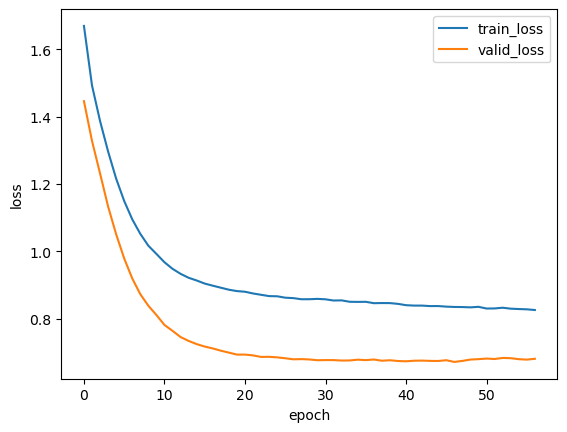

In [11]:
args = {
    'epochs': 100, 
    'path': '/data/pretrained/bert-base-chinese/',
    'emb_dim': 300,
    'hidden_dim': 200,
    'num_layers': 1,
    'n_class': 9, 
    'dropout': 0.2
}
# from sklearn.metrics import accuracy_score
model = LSTMLinear(args, word_emb, tag_dict).to(device)
optimizer = optim.Adam(model.parameters(), lr = 3e-4)
early_stopping = EarlyStopping(patience = 10, verbose = False)
entrophy = nn.CrossEntropyLoss()

avg_train_losses = []
avg_valid_losses = []
for epoch in range(args['epochs']):
    train_correct, train_total, valid_correct, valid_total = 0, 0, 0, 0
    train_losses = []
    valid_losses = []
    model.train()
    for _, batch in enumerate(train_loader):
        tokens, masks, labels = batch
        sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
        tokens = tokens[:, :sen_len]
        masks = masks[:, :sen_len]
        labels = labels[:, :sen_len]
        optimizer.zero_grad()
        output = model(tokens, masks) # (n_batch, n_token, n_class)
        loss = entrophy(output.permute(0, 2, 1), labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        predict = torch.max(output, dim = 2).indices # (n_batch, n_tokens)
        train_correct += torch.sum(predict[masks == 1] == labels[masks == 1]).item()
        train_total += torch.sum(masks == 1).item()
    avg_train_loss = np.average(train_losses)
    avg_train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(valid_loader):
            tokens, masks, labels = batch
            sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
            tokens = tokens[:, :sen_len]
            masks = masks[:, :sen_len]
            labels = labels[:, :sen_len]
            output = model(tokens, masks)
            loss = entrophy(output.permute(0, 2, 1), labels)
            valid_losses.append(loss.item())
            predict = torch.max(output, dim = 2).indices # (n_batch, n_tokens)
            valid_correct += torch.sum(predict[masks == 1] == labels[masks == 1]).item()
            valid_total += torch.sum(masks == 1).item()
        avg_valid_loss = np.average(valid_losses)
        avg_valid_losses.append(avg_valid_loss)
    
    logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
            epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
    early_stopping(avg_valid_loss, model)
    if early_stopping.early_stop:
        logger("Early stopping")
        break


plot_result(avg_train_losses, avg_valid_losses)

In [ ]:
output = model(tokens, masks)
predict = torch.max(output, dim = 2).indices
print(tokens.shape, masks.shape, labels.shape, output.shape, predict.shape)
print(torch.sum(predict[masks == 1] == labels[masks == 1]).item())
print(torch.sum(masks == 1).item())

torch.Size([8, 37]) torch.Size([8, 37]) torch.Size([8, 37]) torch.Size([8, 37, 9]) torch.Size([8, 37])


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        tokens, masks, labels = batch
        sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
        tokens = tokens[:, :sen_len]
        masks = masks[:, :sen_len]
        labels = labels[:, :sen_len]
        output = model(tokens, masks)
        predict = torch.max(output, dim = 2).indices # (n_batch, n_tokens)
        correct += torch.sum(predict[masks == 1] == labels[masks == 1]).item()
        total += torch.sum(masks).item()
#         for j in range(tag_ids.shape[0]):
#             gold_entity = label_sentence_entity(text[j], tag_ids[j].tolist(), self.tag_vocab.ix_to_tag)
#             pred_entity = label_sentence_entity(text[j], predict[j], self.tag_vocab.ix_to_tag)
#             gold_num += len(gold_entity)
#             predict_num += len(pred_entity)
#             for entity in gold_entity:
#                 if entity in pred_entity:
#                     correct_num += 1
#             # print(gold_entity)
#             # print(pred_entity)
#             # return
#     precision = correct_num / (predict_num + 0.000000001)
#     recall = correct_num / (gold_num + 0.000000001)
#     f1 = 2 * precision * recall / (precision + recall + 0.000000001)
#     logger('[Test] Tagging accuracy: {:.8f}'.format(correct / total))
#     logger('[Test] Precision: {:.8f} Recall: {:.8f} F1: {:.8f}'.format(precision, recall, f1))
logger('Tagging accuracy: {}'.format(correct / total))

[20231209 09:51:01] Tagging accuracy: 0.5567050709303237


### LSTM + CRF

In [ ]:
class LSTMCRF(nn.Module):
    def __init__(self, args, word_emb, tag_dict):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(word_emb)
        self.dropout1 = nn.Dropout(p = args['dropout'])
        self.dropout2 = nn.Dropout(p = args['dropout'])
        self.lstm = nn.LSTM(args['emb_dim'], args['hidden_dim'] // 2,
                            num_layers = args['num_layers'], bidirectional=True)
        self.hidden2tag = nn.Linear(args['hidden_dim'], args['n_class'])
        self.crf = CRF({tag_dict[tag]: tag for tag in tag_dict})
        
    def _get_lstm_out(self, tokens, masks):
        embeds = self.word_embedding(tokens)
        embeds = self.dropout1(embeds) # (batch_size, sen_len, 256)
        sen_len = torch.sum(masks, dim = 1, dtype = torch.int64).to('cpu') # (batch_size)
        pack_seq = pack_padded_sequence(embeds, sen_len, batch_first = True, enforce_sorted = False)
        lstm_out, _ = self.lstm(pack_seq)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first = True) # (batch_size, seq_len, hidden_size)
        lstm_feats = self.hidden2tag(lstm_out) # （batch_size, seq_len, tagset_size)
        lstm_feats = self.dropout2(lstm_feats)
        return lstm_feats
    
    def forward(self, tokens, masks, labels):
        lstm_feats = self._get_lstm_out(tokens, masks)
        log_likelihood = self.crf(lstm_feats, labels, masks)
        n_batch = labels.shape[0]
        loss = -log_likelihood / n_batch
        return loss
    
    def predict(self, tokens, masks):
        lstm_feats = self._get_lstm_out(tokens, masks)
        pred = self.crf.viterbi_tags(lstm_feats, masks)
        return pred



[2022-0420 15:24:24] [epoch 1] train_loss: 32.6495 valid_loss: 26.7600
[2022-0420 15:25:06] [epoch 2] train_loss: 27.4287 valid_loss: 24.6578
[2022-0420 15:25:47] [epoch 3] train_loss: 25.8098 valid_loss: 23.3028
[2022-0420 15:26:27] [epoch 4] train_loss: 24.4321 valid_loss: 22.1705
[2022-0420 15:27:08] [epoch 5] train_loss: 23.2464 valid_loss: 21.1355
[2022-0420 15:27:48] [epoch 6] train_loss: 22.2128 valid_loss: 20.2348
[2022-0420 15:28:30] [epoch 7] train_loss: 21.2979 valid_loss: 19.5090
[2022-0420 15:29:06] [epoch 8] train_loss: 20.3794 valid_loss: 18.6468
[2022-0420 15:29:42] [epoch 9] train_loss: 19.6238 valid_loss: 17.9447
[2022-0420 15:30:18] [epoch 10] train_loss: 18.8921 valid_loss: 17.2599
[2022-0420 15:30:54] [epoch 11] train_loss: 18.1530 valid_loss: 16.7047
[2022-0420 15:31:33] [epoch 12] train_loss: 17.4608 valid_loss: 16.0879
[2022-0420 15:32:14] [epoch 13] train_loss: 16.8202 valid_loss: 15.5406
[2022-0420 15:32:55] [epoch 14] train_loss: 16.2445 valid_loss: 15.0764
[

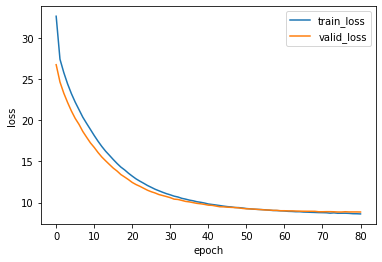

In [ ]:
args = {
    'epochs': 100, 
    'path': '/data/pretrained/bert-base-chinese/',
    'emb_dim': 300,
    'hidden_dim': 200,
    'num_layers': 1,
    'n_class': 9, 
    'dropout': 0.2
}

model = LSTMCRF(args, word_emb, tag_dict).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
early_stopping = EarlyStopping(patience = 10, verbose = False)
entrophy = nn.CrossEntropyLoss()

avg_train_losses = []
avg_valid_losses = []
for epoch in range(args['epochs']):
    train_losses = []
    valid_losses = []
    model.train()
    for _, batch in enumerate(train_loader):
        tokens, masks, labels = batch
        sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
        tokens = tokens[:, :sen_len]
        masks = masks[:, :sen_len]
        labels = labels[:, :sen_len]
        optimizer.zero_grad()
        loss = model(tokens, masks, labels) # (n_batch, n_token, n_class)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    avg_train_loss = np.average(train_losses)
    avg_train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(valid_loader):
            tokens, masks, labels = batch
            sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
            tokens = tokens[:, :sen_len]
            masks = masks[:, :sen_len]
            labels = labels[:, :sen_len]
            loss = model(tokens, masks, labels)
            valid_losses.append(loss.item())
        avg_valid_loss = np.average(valid_losses)
        avg_valid_losses.append(avg_valid_loss)
    
    logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
            epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
    early_stopping(avg_valid_loss, model)
    if early_stopping.early_stop:
        logger("Early stopping")
        break

plot_result(avg_train_losses, avg_valid_losses)

In [ ]:
model.eval()
correct = 0
total = 0
correct_num, gold_num, predict_num = 0, 0, 0
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        tokens, masks, labels = batch
        sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
        tokens = tokens[:, :sen_len]
        masks = masks[:, :sen_len]
        labels = labels[:, :sen_len]
        predict = model.predict(tokens, masks)
#         predict = torch.max(output, dim = 2).indices # (n_batch, n_tokens)
        correct += torch.sum(predict[masks == 1] == labels[masks == 1]).item()
        total += torch.sum(masks).item()
        for j in range(labels.shape[0]):
            text = [word_list[int(w)] for w in tokens[j][masks[j] == 1]]
            gold_entity = label_sentence_entity(text, labels[j].tolist(), tag_list)
            pred_entity = label_sentence_entity(text, predict[j], tag_list)
            gold_num += len(gold_entity)
            predict_num += len(pred_entity)
            for entity in gold_entity:
                if entity in pred_entity:
                    correct_num += 1
#             print(gold_entity)
#             print(pred_entity)
#             gold_entity()
    precision = correct_num / (predict_num + 0.000000001)
    recall = correct_num / (gold_num + 0.000000001)
    f1 = 2 * precision * recall / (precision + recall + 0.000000001)
    logger('[Test] Tagging accuracy: {:.8f}'.format(correct / total))
    logger('[Test] Precision: {:.8f} Recall: {:.8f} F1: {:.8f}'.format(precision, recall, f1))
logger('Tagging accuracy: {}'.format(correct / total))

[2022-0420 16:59:50] [Test] Tagging accuracy: 0.52943021
[2022-0420 16:59:50] [Test] Precision: 0.21648288 Recall: 0.12275794 F1: 0.15667332
[2022-0420 16:59:50] Tagging accuracy: 0.5294302061290069


## Bert Model

In [8]:
def evaluate(model, test_loader, tag_list):
    model.eval()
    correct_num, predict_num, gold_num = 0, 0, 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # tokens, masks, labels, texts = batch
            # print(tokens.shape, masks.shape, labels.shape, len(texts))
            # sen_len = torch.max(torch.sum(masks, dim = 1, dtype = torch.int64)).item()
            # output = model(**batch) # (n_batch, n_token, n_class)
            tokens, masks, labels, texts = batch['tokens'], batch['masks'], batch['labels'], batch['texts']
            sen_len = max(len(text) for text in texts)
            # tokens = tokens[:, :sen_len]
            # masks = masks[:, :sen_len]
            labels = labels[:, :sen_len]
            pred = model.predict(**batch)[:, :sen_len]
            # print(pred)
            for j in range(labels.shape[0]):
                gold_entity = label_sentence_entity(texts[j], labels[j].tolist(), tag_list)
                pred_entity = label_sentence_entity(texts[j], pred[j], tag_list)
                gold_num += len(gold_entity)
                predict_num += len(pred_entity)
                for entity in gold_entity:
                    if entity in pred_entity:
                        correct_num += 1
                # print(gold_entity)
                # print(pred_entity)
                # return
    precision = correct_num / (predict_num + 0.000000001)
    recall = correct_num / (gold_num + 0.000000001)
    f1 = 2 * precision * recall / (precision + recall + 0.000000001)
    logger('[Test] Precision: {:.6f} Recall: {:.6f} F1: {:.6f}'.format(precision, recall, f1))
    return precision, recall, f1

# evaluate(model, test_loader, tag_list)

In [9]:
import time
def save_model(model, path):
    ts = time.strftime('%m%d%H%M', time.localtime())
    torch.save(model.state_dict(), '{}.{}'.format(path, ts))
    print('Save model to', '{}.{}'.format(path, ts))

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def cls_metrics(model, data_loader):
    all_label = []
    all_pred = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels, texts = batch
            logits = model(input_ids, attention_mask)['logits']
            pred = torch.argmax(logits, dim = 1)
            all_label.extend(labels.tolist())
            all_pred.extend(pred.detach().cpu().numpy().tolist())
    acc = accuracy_score(all_label, all_pred)
    p = precision_score(all_label, all_pred, average = 'macro')
    r = recall_score(all_label, all_pred, average = 'macro')
    f1 = f1_score(all_label, all_pred, average = 'macro')
    # logger('[Eval] {} Acc: {:.4f}, P: {:.4f}, R: {:.4f}, F1: {:.4f}'.format(data_loader.__str__, acc, p, r, f1))
    return acc, p, r, f1

In [11]:
def train(model, train_loader, valid_loader, epochs = 100, lr = 1e-5):
    print('Train {} model with lr = {}'.format(model.__class__.__name__, lr))
    optimizer = optim.Adam(model.parameters(), lr)
    early_stopping = EarlyStopping(patience = 5, verbose = False)
    entrophy = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        valid_correct = 0
        valid_total = 0
        train_correct = 0
        train_total = 0
        train_losses = []
        valid_losses = []
        model.train()
        for _, batch in enumerate(train_loader):
            optimizer.zero_grad()
            # tokens, masks, labels, texts = batch
            # output = model(tokens, masks, labels) # (n_batch, n_token, n_class)
            output = model(**batch) # (n_batch, n_token, n_class)
            masks, labels = batch['masks'], batch['labels']
            loss = entrophy(output.permute(0, 2, 1), labels[:, :output.shape[1]])
            # loss = entrophy(output.permute(0, 2, 1), labels[:])
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            predict = torch.max(output, dim = 2).indices # (n_batch, n_tokens)
            # train_correct += torch.sum(predict == labels[:, :output.shape[1]]).item()
            train_correct += torch.sum(torch.logical_and(predict == labels[:, :output.shape[1]], masks == 1)).item()
            train_total += torch.sum(masks == 1).item()
        avg_train_loss = np.average(train_losses)

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                tokens, masks, labels, texts = batch
                # output = model(tokens, masks, labels)
                output = model(**batch)
                masks, labels = batch['masks'], batch['labels']
                loss = entrophy(output.permute(0, 2, 1), labels[:, :output.shape[1]])
                valid_losses.append(loss.item())
                predict = torch.max(output, dim = 2).indices # (n_batch, n_tokens)
                # valid_correct += torch.sum(predict == labels[:, :output.shape[1]]).item()
                valid_correct += torch.sum(torch.logical_and(predict == labels[:, :output.shape[1]], masks == 1)).item()
                valid_total += torch.sum(masks == 1).item()
            avg_valid_loss = np.average(valid_losses)
        precision, recall, f1 = evaluate(model, valid_loader, tag_list)
        
        # logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
        #     epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
        logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
            epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
        # logger('Precision: {:.3f} Recall: {:.3f} F1: {:.3f}'.format(precision, recall, f1))
        # early_stopping(f1, model)
        early_stopping(-valid_correct / valid_total, model)
        if early_stopping.early_stop:
            logger("Early stopping")
            break
    save_model(model, './results/{}.{}'.format(model.__class__.__name__, lr))
    return model


In [12]:
def train_crf(model, epochs = 100, lr = 1e-5):
    print('Train {} model with lr = {}'.format(model.__class__.__name__, lr))
    optimizer = optim.Adam(model.parameters(), lr)
    early_stopping = EarlyStopping(patience = 5, verbose = False)
    entrophy = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        valid_correct = 0
        valid_total = 0
        train_correct = 0
        train_total = 0
        train_losses = []
        valid_losses = []
        model.train()
        for _, batch in enumerate(train_loader):
            # tokens, masks, labels, texts = batch
            optimizer.zero_grad()
            # loss = model(tokens, masks, labels) # (n_batch, n_token, n_class)
            masks, labels = batch['masks'], batch['labels']
            loss = model(**batch) # (n_batch, n_token, n_class)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            predict = model.predict(**batch) # (n_batch, n_tokens)
            # train_correct += torch.sum(predict == labels[:, :output.shape[1]]).item()
            train_correct += torch.sum(torch.logical_and(predict == labels[:, :predict.shape[1]], masks == 1)).item()
            train_total += torch.sum(masks == 1).item()
        avg_train_loss = np.average(train_losses)

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # tokens, masks, labels, texts = batch
                # loss = model(tokens, masks, labels)
                masks, labels = batch['masks'], batch['labels']
                loss = model(**batch)
                valid_losses.append(loss.item())
                predict = model.predict(**batch)
                # predict = model.predict(tokens, masks) # (n_batch, n_tokens)
                # valid_correct += torch.sum(predict == labels[:, :predict.shape[1]]).item()
                valid_correct += torch.sum(torch.logical_and(predict == labels[:, :predict.shape[1]], masks == 1)).item()
                valid_total += torch.sum(masks == 1).item()
            avg_valid_loss = np.average(valid_losses)
        precision, recall, f1 = evaluate(model, valid_loader, tag_list)
        
        # logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
        #     epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
        logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
            epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
        # logger('Precision: {:.3f} Recall: {:.3f} F1: {:.3f}'.format(precision, recall, f1))
        # early_stopping(f1, model)
        early_stopping(-valid_correct / valid_total, model)
        if early_stopping.early_stop:
            logger("Early stopping")
            break
    save_model(model, './results/{}.{}'.format(model.__class__.__name__, lr))
    return model


In [21]:
# load dataset
args = {
    'path': '/data/pretrained/bert-base-chinese/',
    'bert_out_dim': 768,
    'n_class': 9, 
    'dropout': 0.2
}
tokenizer = AutoTokenizer.from_pretrained('/data/pretrained/bert-base-chinese/')
def collate(batch):
    tokens = tokenizer([item['text'] for item in batch], 
                       padding = 'max_length', truncation = True, max_length = 40, return_tensors = 'pt')
    labels = torch.tensor([item['labels'] for item in batch], dtype = torch.long, device = device)
    # entity_embeds = torch.tensor([item['entity_embeds'] for item in batch], dtype = torch.float, device = device)
    # return tokens['input_ids'].to(device), tokens['attention_mask'].to(device), labels, [item['text'] for item in batch]
    return {
        'tokens': tokens['input_ids'].to(device),
        'masks': tokens['attention_mask'].to(device),
        'labels': labels,
        'texts': [item['text'] for item in batch],
        # 'entity_embeds': entity_embeds,
    }

n_train, n_dev = int(0.6 * len(tagged_dataset)), int(0.2 * len(tagged_dataset))
batch_size = 8
train_loader = DataLoader(tagged_dataset[:n_train], batch_size = batch_size, collate_fn = collate)
valid_loader = DataLoader(tagged_dataset[n_train: n_train + n_dev], batch_size = batch_size, collate_fn = collate)
test_loader = DataLoader(tagged_dataset[n_train + n_dev:], batch_size = batch_size, collate_fn = collate)

### BertLinear

In [ ]:
class BertLinear(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'], args['n_class'])
        
    def forward(self, tokens, masks, labels = None):
        bert_out = self.bert(tokens, masks)['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        cls_out = self.cls(bert_out)
        return cls_out

    def predict(self, tokens, masks):
        cls_out = self.forward(tokens, masks)
        pred = torch.max(cls_out, dim = 2).indices
        return pred

# model = BertLinear(args, tokenizer, tag_dict).to(device)


In [16]:
# BertLinear
model = BertLinear(args).to(device)
train(model, epochs = 100, lr = 1e-6)
evaluate(model, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[20231212 10:18:27] [Test] Precision: 0.090909 Recall: 0.023110 F1: 0.036852
[20231212 10:18:27] [epoch 1] TLoss: 1.018 VLoss: 0.617 TAcc

(0.5550883095036679, 0.4344248806976412, 0.48739961180310787)

In [21]:
save_model(model, './results/bert_linear.{}'.format(1e-6))

Save model to ./results/bert_linear.1e-06.12121051


In [ ]:
# BertLinear
model = BertLinear(args).to(device)
train(model, epochs = 100, lr = 1e-6)
evaluate(model, test_loader, tag_list)

### BertMLP

In [14]:
args = {
    'path': '/data/pretrained/bert-base-chinese/',
    'bert_out_dim': 768,
    'n_class': 9, 
    'dropout': 0.2
}

class BertMLP(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Sequential(
            nn.Linear(args['bert_out_dim'], 600),
            nn.ReLU(),
            nn.Linear(600, 200),
            nn.ReLU(),
            nn.Linear(200, args['n_class']),
        )
        
    def forward(self, tokens, masks, labels = None):
        bert_out = self.bert(tokens, masks)['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        cls_out = self.cls(bert_out)
        return cls_out

    def predict(self, tokens, masks):
        cls_out = self.forward(tokens, masks)
        pred = torch.max(cls_out, dim = 2).indices
        return pred

In [19]:
# BertLinear
model = BertMLP(args).to(device)
train(model, epochs = 100, lr = 1e-7)
evaluate(model, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertMLP model with lr = 1e-07


[20231216 23:08:42] [Test] Precision: 0.005334 Recall: 0.003220 F1: 0.004016
[20231216 23:08:42] [epoch 1] TLoss: 2.208 VLoss: 2.095 TAcc: 0.093 VAcc: 0.469
[20231216 23:09:41] [Test] Precision: 0.000000 Recall: 0.000000 F1: 0.000000
[20231216 23:09:41] [epoch 2] TLoss: 1.995 VLoss: 1.756 TAcc: 0.438 VAcc: 0.646
[20231216 23:10:42] [Test] Precision: 0.000000 Recall: 0.000000 F1: 0.000000
[20231216 23:10:42] [epoch 3] TLoss: 1.686 VLoss: 1.423 TAcc: 0.511 VAcc: 0.646
[20231216 23:11:43] [Test] Precision: 0.000000 Recall: 0.000000 F1: 0.000000
[20231216 23:11:43] [epoch 4] TLoss: 1.476 VLoss: 1.241 TAcc: 0.511 VAcc: 0.646
[20231216 23:12:44] [Test] Precision: 0.000000 Recall: 0.000000 F1: 0.000000
[20231216 23:12:44] [epoch 5] TLoss: 1.355 VLoss: 1.134 TAcc: 0.511 VAcc: 0.646
[20231216 23:13:46] [Test] Precision: 0.000000 Recall: 0.000000 F1: 0.000000
[20231216 23:13:46] [epoch 6] TLoss: 1.276 VLoss: 1.065 TAcc: 0.511 VAcc: 0.646
[20231216 23:14:53] [Test] Precision: 0.000000 Recall: 0.0

Save model to ./results/BertMLP.1e-07.12162326


[20231216 23:26:39] [Test] Precision: 0.000000 Recall: 0.000000 F1: 0.000000


(0.0, 0.0, 0.0)

In [19]:
model = BertMLP(args).to(device)
train(model, epochs = 100, lr = 1e-7)
evaluate(model, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[20231212 14:33:05] [Test] Precision: 0.001556 Recall: 0.000758 F1: 0.001019
[20231212 14:33:05] [epoch 1] TLoss: 2.257 VLoss: 2.126 TAcc

NameError: name 'save_model' is not defined

### BertCRF

In [16]:
args = {
    'path': '/data/pretrained/bert-base-chinese/',
    'bert_out_dim': 768,
    'n_class': 9, 
    'dropout': 0.2
}

class BertCRF(nn.Module):
    def __init__(self, args, tag_dict):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'], args['n_class'])
        self.crf = CRF({tag_dict[tag]: tag for tag in tag_dict})
        
    def forward(self, tokens, masks, labels):
        bert_out = self.bert(tokens)['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        cls_out = self.cls(bert_out)
        log_likelihood = self.crf(cls_out, labels, masks)
        n_batch = labels.shape[0]
        loss = -log_likelihood / n_batch
        return loss
    
    def predict(self, tokens, masks):
        bert_out = self.bert(tokens)['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        cls_out = self.cls(bert_out)
        predict = self.crf.viterbi_tags(cls_out, masks)
        return predict



In [37]:
model_crf = BertCRF(args, tag_dict).to(device)
train_crf(model_crf, epochs = 100, lr = 1e-6)
evaluate(model_crf, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRF model with lr = 1e-06


[20231216 23:39:03] [Test] Precision: 0.473161 Recall: 0.387384 F1: 0.425997
[20231216 23:39:03] [epoch 1] TLoss: 38.404 VLoss: 27.757 TAcc: 0.535 VAcc: 0.717
[20231216 23:40:54] [Test] Precision: 0.487606 Recall: 0.555219 F1: 0.519221
[20231216 23:40:54] [epoch 2] TLoss: 27.129 VLoss: 25.005 TAcc: 0.684 VAcc: 0.713
[20231216 23:42:46] [Test] Precision: 0.502083 Recall: 0.593484 F1: 0.543971
[20231216 23:42:46] [epoch 3] TLoss: 23.824 VLoss: 24.169 TAcc: 0.717 VAcc: 0.717
[20231216 23:44:37] [Test] Precision: 0.511860 Recall: 0.613184 F1: 0.557959
[20231216 23:44:37] [epoch 4] TLoss: 22.174 VLoss: 24.033 TAcc: 0.732 VAcc: 0.718
[20231216 23:46:30] [Test] Precision: 0.520691 Recall: 0.605418 F1: 0.559867
[20231216 23:46:30] [epoch 5] TLoss: 21.126 VLoss: 23.763 TAcc: 0.744 VAcc: 0.720
[20231216 23:48:23] [Test] Precision: 0.525847 Recall: 0.626255 F1: 0.571676
[20231216 23:48:23] [epoch 6] TLoss: 20.333 VLoss: 23.620 TAcc: 0.751 VAcc: 0.723
[20231216 23:50:17] [Test] Precision: 0.528587

In [18]:
model_crf = BertCRF(args, tag_dict).to(device)
model_crf.load_state_dict(torch.load('./results/BertCRF.1e-06.12170022'))
evaluate(model_crf, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[20231217 09:01:28] [Test] Precision: 0.560790 Recall: 0.556360 F1: 0.558566


(0.5607895173327979, 0.5563600460752746, 0.5585659998303302)

In [19]:
# model_crf2 = BertCRF(args, tag_dict).to(device)
# train_crf(model_crf2, epochs = 100, lr = 1e-7)
# evaluate(model_crf2, test_loader, tag_list)
model_crf2 = BertCRF(args, tag_dict).to(device)
model_crf2.load_state_dict(torch.load('./results/BertCRF.1e-07.12170059'))
evaluate(model_crf2, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[20231217 09:01:43] [Test] Precision: 0.560538 Recall: 0.431957 F1: 0.487918


(0.5605381165918085, 0.43195655751185913, 0.48791821512168426)

In [20]:
for i in range(5):
    model_crf = BertCRF(args, tag_dict).to(device)
    train_crf(model_crf, epochs = 100, lr = 1e-6)
    evaluate(model_crf, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRF model with lr = 1e-06


[20231217 09:06:06] [Test] Precision: 0.269629 Recall: 0.187346 F1: 0.221080
[20231217 09:06:06] [epoch 1] TLoss: 30.753 VLoss: 22.185 TAcc: 0.545 VAcc: 0.657
[20231217 09:08:01] [Test] Precision: 0.492911 Recall: 0.592726 F1: 0.538230
[20231217 09:08:01] [epoch 2] TLoss: 20.251 VLoss: 19.265 TAcc: 0.681 VAcc: 0.705
[20231217 09:09:52] [Test] Precision: 0.504821 Recall: 0.634779 F1: 0.562390
[20231217 09:09:52] [epoch 3] TLoss: 17.375 VLoss: 18.661 TAcc: 0.717 VAcc: 0.703
[20231217 09:11:44] [Test] Precision: 0.524244 Recall: 0.653343 F1: 0.581717
[20231217 09:11:44] [epoch 4] TLoss: 15.903 VLoss: 17.999 TAcc: 0.736 VAcc: 0.715
[20231217 09:13:39] [Test] Precision: 0.529870 Recall: 0.656943 F1: 0.586604
[20231217 09:13:39] [epoch 5] TLoss: 15.144 VLoss: 17.868 TAcc: 0.745 VAcc: 0.713
[20231217 09:15:32] [Test] Precision: 0.535856 Recall: 0.665278 F1: 0.593594
[20231217 09:15:32] [epoch 6] TLoss: 14.659 VLoss: 17.694 TAcc: 0.751 VAcc: 0.713
[20231217 09:17:24] [Test] Precision: 0.534519

Save model to ./results/BertCRF.1e-06.12170921


[20231217 09:21:16] [Test] Precision: 0.562439 Recall: 0.564752 F1: 0.563593
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRF model with lr = 1e-06


[20231217 09:23:10] [Test] Precision: 0.416093 Recall: 0.366357 F1: 0.389644
[20231217 09:23:10] [epoch 1] TLoss: 34.723 VLoss: 25.458 TAcc: 0.555 VAcc: 0.695
[20231217 09:25:04] [Test] Precision: 0.481137 Recall: 0.577382 F1: 0.524884
[20231217 09:25:04] [epoch 2] TLoss: 24.535 VLoss: 22.862 TAcc: 0.682 VAcc: 0.708
[20231217 09:26:57] [Test] Precision: 0.503340 Recall: 0.627960 F1: 0.558786
[20231217 09:26:57] [epoch 3] TLoss: 21.594 VLoss: 21.971 TAcc: 0.714 VAcc: 0.716
[20231217 09:28:51] [Test] Precision: 0.509851 Recall: 0.642167 F1: 0.568410
[20231217 09:28:51] [epoch 4] TLoss: 20.117 VLoss: 21.616 TAcc: 0.731 VAcc: 0.717
[20231217 09:30:47] [Test] Precision: 0.518418 Recall: 0.650502 F1: 0.576997
[20231217 09:30:47] [epoch 5] TLoss: 19.194 VLoss: 21.157 TAcc: 0.743 VAcc: 0.721
[20231217 09:32:41] [Test] Precision: 0.527511 Recall: 0.633832 F1: 0.575805
[20231217 09:32:41] [epoch 6] TLoss: 18.534 VLoss: 21.016 TAcc: 0.751 VAcc: 0.721
[20231217 09:34:36] [Test] Precision: 0.529847

Save model to ./results/BertCRF.1e-06.12171000


[20231217 10:01:05] [Test] Precision: 0.553979 Recall: 0.558993 F1: 0.556475
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRF model with lr = 1e-06


[20231217 10:02:58] [Test] Precision: 0.487526 Recall: 0.307255 F1: 0.376946
[20231217 10:02:58] [epoch 1] TLoss: 34.027 VLoss: 24.537 TAcc: 0.528 VAcc: 0.713
[20231217 10:04:52] [Test] Precision: 0.492867 Recall: 0.595567 F1: 0.539372
[20231217 10:04:52] [epoch 2] TLoss: 23.088 VLoss: 21.498 TAcc: 0.679 VAcc: 0.711
[20231217 10:06:44] [Test] Precision: 0.507225 Recall: 0.645009 F1: 0.567879
[20231217 10:06:44] [epoch 3] TLoss: 19.970 VLoss: 20.499 TAcc: 0.714 VAcc: 0.717
[20231217 10:08:39] [Test] Precision: 0.521043 Recall: 0.666035 F1: 0.584684
[20231217 10:08:39] [epoch 4] TLoss: 18.584 VLoss: 19.945 TAcc: 0.730 VAcc: 0.722
[20231217 10:10:34] [Test] Precision: 0.526199 Recall: 0.673423 F1: 0.590777
[20231217 10:10:34] [epoch 5] TLoss: 17.646 VLoss: 19.978 TAcc: 0.741 VAcc: 0.719
[20231217 10:12:25] [Test] Precision: 0.530070 Recall: 0.672855 F1: 0.592988
[20231217 10:12:25] [epoch 6] TLoss: 17.005 VLoss: 19.802 TAcc: 0.750 VAcc: 0.719
[20231217 10:14:19] [Test] Precision: 0.530582

Save model to ./results/BertCRF.1e-06.12171018


[20231217 10:18:12] [Test] Precision: 0.565120 Recall: 0.579069 F1: 0.572009
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRF model with lr = 1e-06


[20231217 10:20:05] [Test] Precision: 0.183130 Recall: 0.122561 F1: 0.146845
[20231217 10:20:05] [epoch 1] TLoss: 36.629 VLoss: 27.967 TAcc: 0.519 VAcc: 0.641
[20231217 10:21:59] [Test] Precision: 0.472727 Recall: 0.517143 F1: 0.493939
[20231217 10:21:59] [epoch 2] TLoss: 25.149 VLoss: 23.408 TAcc: 0.663 VAcc: 0.697
[20231217 10:23:53] [Test] Precision: 0.504976 Recall: 0.605607 F1: 0.550732
[20231217 10:23:53] [epoch 3] TLoss: 21.201 VLoss: 22.166 TAcc: 0.714 VAcc: 0.712
[20231217 10:25:46] [Test] Precision: 0.512605 Recall: 0.635537 F1: 0.567490
[20231217 10:25:46] [epoch 4] TLoss: 19.556 VLoss: 21.771 TAcc: 0.730 VAcc: 0.712
[20231217 10:27:39] [Test] Precision: 0.522219 Recall: 0.645577 F1: 0.577382
[20231217 10:27:39] [epoch 5] TLoss: 18.569 VLoss: 21.292 TAcc: 0.742 VAcc: 0.719
[20231217 10:29:34] [Test] Precision: 0.521306 Recall: 0.653533 F1: 0.579978
[20231217 10:29:34] [epoch 6] TLoss: 17.893 VLoss: 21.318 TAcc: 0.751 VAcc: 0.715
[20231217 10:31:27] [Test] Precision: 0.525809

Save model to ./results/BertCRF.1e-06.12171037


[20231217 10:37:13] [Test] Precision: 0.564120 Recall: 0.551588 F1: 0.557784
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRF model with lr = 1e-06


[20231217 10:39:06] [Test] Precision: 0.330898 Recall: 0.240197 F1: 0.278345
[20231217 10:39:06] [epoch 1] TLoss: 34.618 VLoss: 24.280 TAcc: 0.542 VAcc: 0.685
[20231217 10:41:02] [Test] Precision: 0.489507 Recall: 0.569994 F1: 0.526694
[20231217 10:41:02] [epoch 2] TLoss: 24.361 VLoss: 21.827 TAcc: 0.674 VAcc: 0.718
[20231217 10:42:55] [Test] Precision: 0.507439 Recall: 0.613753 F1: 0.555556
[20231217 10:42:55] [epoch 3] TLoss: 21.248 VLoss: 21.135 TAcc: 0.714 VAcc: 0.719
[20231217 10:44:48] [Test] Precision: 0.520343 Recall: 0.644440 F1: 0.575781
[20231217 10:44:48] [epoch 4] TLoss: 19.739 VLoss: 20.558 TAcc: 0.731 VAcc: 0.720
[20231217 10:46:41] [Test] Precision: 0.525260 Recall: 0.659784 F1: 0.584887
[20231217 10:46:41] [epoch 5] TLoss: 18.723 VLoss: 20.040 TAcc: 0.743 VAcc: 0.721
[20231217 10:48:34] [Test] Precision: 0.531663 Recall: 0.663194 F1: 0.590189
[20231217 10:48:34] [epoch 6] TLoss: 17.923 VLoss: 19.885 TAcc: 0.751 VAcc: 0.721
[20231217 10:50:27] [Test] Precision: 0.532393

Save model to ./results/BertCRF.1e-06.12171103


[20231217 11:03:47] [Test] Precision: 0.556720 Recall: 0.559651 F1: 0.558182


### Entity Rule

In [ ]:
from JDComment_seg.code_kg.kg_embed import getAllEntityTriplet, getEntity, getTriplet, loadBertEmbed, getTopEntityTriplet
from_file = '/home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt'

# targets, opinions
target_ids, opinion_ids, target_list, opinion_list = getEntity(from_file)
# target->opinions, opinion->targets
target_triplet_dict, opinion_triplet_dict = getAllEntityTriplet()
# triplets
triplet_dict = getTriplet(from_file) # triplet_dict: 148600

In [ ]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

def match_entities(text, target_list):
    matched_entities = []
    words = seg_words(text).split()
    matched_entities = [word for word in words if word in target_list]
    for word in words:
        if word in target_list:
            matched_entities.append(word)
    return matched_entities

def match_triplets(text, target_list, opinion_list):
    matched_triplets = []
    words = seg_words(text).split()
    for word in words:
        if word in target_list:
            matched_triplets.append(target_triplet_dict[word])
        elif word in opinion_list:
            matched_triplets.append(opinion_triplet_dict[word])
    return matched_triplets

text = "I bought a new iPhone yesterday."
matched_entities = match_entities(text, target_list)
print(matched_entities)


### BertEntity

In [13]:
from JDComment_seg.code_kg.kg_embed import getAllEntityTriplet, getEntity, loadBertEmbed, getTopEntityTriplet
from_file = '/home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt'

# targets, opinions
target_ids, opinion_ids, target_list, opinion_list = getEntity(from_file)
# target->opinions, opinion->targets
target_triplet_dict, opinion_triplet_dict = getAllEntityTriplet()
# TransE embedding
enhanced_target_embed, enhanced_opinion_embed, target_list, opinion_list = loadBertEmbed()
target_top_triplet_dict, opinion_top_triplet_dict = getTopEntityTriplet()

Get entity from data_file: /home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt, target_ids: 12122, opinion_ids: 34028
Get entity triplet from data_file: /home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt, target_dict: 12122, opinion_dict: 34028
Get entity top triplets, target_dict: /home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt, opinion_dict: 12122


In [14]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

# Use Enhanced Embedding
# 对于每个target，使用Top tail entity进行加权, [entity_emb; avg(tail_emb)]
def embed_text(text, max_len = 40):
    words = seg_words(text)
    # embeds = torch.zeros((len(text), 768 * 2), dtype = torch.float32) # sen_len, emb_size
    embeds = torch.zeros((max_len, 768 * 2), dtype = torch.float32) # sen_len, emb_size
    pos = 1 # [CLS]
    for word in words:
        if word in target_ids:
            embeds[pos: pos + len(word)] += enhanced_target_embed[target_ids[word]]
        if word in opinion_ids:
            embeds[pos: pos + len(word)] += enhanced_opinion_embed[opinion_ids[word]]
        pos += len(word)
    return embeds



In [64]:
# # 对于数据集中的所有输入文本做预处理，提前计算固定的entity embedding
# for item in tagged_dataset:
#     text = item['text']
#     embed = embed_text(text)
#     item['entity_embeds'] = embed.numpy()

# def collate_ent(batch):
#     tokens = tokenizer([item['text'] for item in batch], 
#                        padding = 'max_length', truncation = True, max_length = 40, return_tensors = 'pt')
#     labels = torch.tensor([item['labels'] for item in batch], dtype = torch.long, device = device)
#     entity_embeds = torch.tensor([item['entity_embeds'] for item in batch], dtype = torch.float, device = device)
#     return {
#         'tokens': tokens['input_ids'].to(device),
#         'masks': tokens['attention_mask'].to(device),
#         'labels': labels,
#         'texts': [item['text'] for item in batch],
#         'entity_embeds': entity_embeds,
#     }

# n_train, n_dev = int(0.6 * len(tagged_dataset)), int(0.2 * len(tagged_dataset))
# batch_size = 8
# train_loader_ent = DataLoader(tagged_dataset[:n_train], batch_size = batch_size, collate_fn = collate_ent)
# valid_loader_ent = DataLoader(tagged_dataset[n_train: n_train + n_dev], batch_size = batch_size, collate_fn = collate_ent)
# test_loader_ent = DataLoader(tagged_dataset[n_train + n_dev:], batch_size = batch_size, collate_fn = collate_ent)

In [14]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

# 对于每个target，同时使用Top tail entity进行加权, [entity_emb; avg(tail_emb)]
def embed_bert_text(text, max_len = 40):
    words = seg_words(text)
    embeds = torch.zeros((max_len, 768 * 2), dtype = torch.float32) # sen_len, emb_size
    pos = 1 # [CLS]
    for word in words:
        if word in target_ids:
            embeds[pos: pos + len(word)] += enhanced_target_embed[target_ids[word]]
        if word in opinion_ids:
            embeds[pos: pos + len(word)] += enhanced_opinion_embed[opinion_ids[word]]
        pos += len(word)
    return embeds

class BertEntity(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'] * 3, args['n_class'])
    
    def ent_layer(self, texts, bert_out):
        ent_embeds = [embed_bert_text(text, max_len = bert_out.shape[1]) for text in texts]
        ent_embeds = torch.stack(ent_embeds)
        return ent_embeds.cuda()
    
    def forward(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        return cls_out

    def predict(self, **batch):
        cls_out = self.forward(**batch)
        # cls_out = self.forward({'tokens': tokens, 'masks': masks})
        pred = torch.max(cls_out, dim = 2).indices
        return pred

# model_ent = BertEntity(args).to(device)
# model_ent.predict(tokens = 1, masks = 2, texts = 3)

In [64]:
model_ent = BertEntity(args).to(device)
train(model_ent, train_loader, valid_loader, epochs = 100, lr = 1e-6)
evaluate(model_ent, test_loader, tag_list)

Train BertEntity model with lr = 1e-06


[20231217 15:08:37] [Test] Precision: 0.002572 Recall: 0.000947 F1: 0.001384
[20231217 15:08:37] [epoch 1] TLoss: 46.004 VLoss: 30.462 TAcc: 0.402 VAcc: 0.480
[20231217 15:09:40] [Test] Precision: 0.049020 Recall: 0.023679 F1: 0.031933
[20231217 15:09:40] [epoch 2] TLoss: 10.692 VLoss: 4.877 TAcc: 0.467 VAcc: 0.510
[20231217 15:10:43] [Test] Precision: 0.183801 Recall: 0.150028 F1: 0.165207
[20231217 15:10:43] [epoch 3] TLoss: 3.415 VLoss: 3.003 TAcc: 0.540 VAcc: 0.556
[20231217 15:11:47] [Test] Precision: 0.236123 Recall: 0.209509 F1: 0.222021
[20231217 15:11:47] [epoch 4] TLoss: 2.311 VLoss: 2.342 TAcc: 0.594 VAcc: 0.597
[20231217 15:12:50] [Test] Precision: 0.275250 Recall: 0.261224 F1: 0.268053
[20231217 15:12:50] [epoch 5] TLoss: 1.840 VLoss: 1.892 TAcc: 0.622 VAcc: 0.617
[20231217 15:13:53] [Test] Precision: 0.365740 Recall: 0.386247 F1: 0.375714
[20231217 15:13:53] [epoch 6] TLoss: 1.520 VLoss: 1.669 TAcc: 0.645 VAcc: 0.644
[20231217 15:14:59] [Test] Precision: 0.407740 Recall: 

Save model to ./results/BertEntity.1e-06.12171545


[20231217 15:45:25] [Test] Precision: 0.486756 Recall: 0.474741 F1: 0.480673


(0.4867555255609099, 0.4747408260654147, 0.4806731084636767)

In [69]:
model_ent = BertEntity(args).to(device)
train(model_ent, train_loader, valid_loader, epochs = 100, lr = 2e-6)
evaluate(model_ent, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertEntity model with lr = 2e-06


[20231217 17:19:28] [Test] Precision: 0.067023 Recall: 0.035613 F1: 0.046512
[20231217 17:19:28] [epoch 1] TLoss: 18.143 VLoss: 5.282 TAcc: 0.495 VAcc: 0.562
[20231217 17:20:32] [Test] Precision: 0.218950 Recall: 0.201364 F1: 0.209789
[20231217 17:20:32] [epoch 2] TLoss: 3.529 VLoss: 2.998 TAcc: 0.578 VAcc: 0.616
[20231217 17:21:37] [Test] Precision: 0.297943 Recall: 0.290775 F1: 0.294315
[20231217 17:21:37] [epoch 3] TLoss: 2.470 VLoss: 2.162 TAcc: 0.630 VAcc: 0.633
[20231217 17:22:41] [Test] Precision: 0.388535 Recall: 0.392877 F1: 0.390694
[20231217 17:22:41] [epoch 4] TLoss: 1.832 VLoss: 1.630 TAcc: 0.659 VAcc: 0.650
[20231217 17:23:45] [Test] Precision: 0.405358 Recall: 0.441371 F1: 0.422599
[20231217 17:23:45] [epoch 5] TLoss: 1.478 VLoss: 1.429 TAcc: 0.678 VAcc: 0.649
[20231217 17:24:48] [Test] Precision: 0.435022 Recall: 0.494601 F1: 0.462902
[20231217 17:24:48] [epoch 6] TLoss: 1.229 VLoss: 1.279 TAcc: 0.695 VAcc: 0.659
[20231217 17:25:52] [Test] Precision: 0.450931 Recall: 0.

Save model to ./results/BertEntity.2e-06.12171748


[20231217 17:48:56] [Test] Precision: 0.489816 Recall: 0.498601 F1: 0.494169


(0.4898157129000178, 0.4986012835279745, 0.4941694523255318)

In [ ]:
for i in range(5):
    model_ent = BertEntity(args).to(device)
    train(model_ent, train_loader, valid_loader, epochs = 100, lr = 1e-6)
    evaluate(model_ent, test_loader, tag_list)

In [66]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

# 对于每个target，同时使用Top tail entity进行加权, [entity_emb; avg(tail_emb)]
def embed_bert_text2(text, max_len = 40):
    words = seg_words(text)
    embeds = torch.zeros((max_len, 768), dtype = torch.float32) # sen_len, emb_size
    pos = 1 # [CLS]
    for word in words:
        if word in target_ids:
            embeds[pos: pos + len(word)] += enhanced_target_embed[target_ids[word]][768:]
        if word in opinion_ids:
            embeds[pos: pos + len(word)] += enhanced_opinion_embed[opinion_ids[word]][768:]
        pos += len(word)
    return embeds

class BertEntity2(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'], args['n_class'])
    
    def ent_layer(self, texts, bert_out):
        ent_embeds = [embed_bert_text2(text, max_len = bert_out.shape[1]) for text in texts]
        ent_embeds = torch.stack(ent_embeds)
        return ent_embeds.cuda()
    
    def forward(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = bert_out + ent_embeds
        # bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        return cls_out

    def predict(self, **batch):
        cls_out = self.forward(**batch)
        pred = torch.max(cls_out, dim = 2).indices
        return pred

# model_ent = BertEntity(args).to(device)
# model_ent.predict(tokens = 1, masks = 2, texts = 3)

In [67]:
model_ent2 = BertEntity2(args).to(device)
train(model_ent2, train_loader, valid_loader, epochs = 100, lr = 1e-6)
evaluate(model_ent2, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertEntity2 model with lr = 1e-06


[20231217 15:50:19] [Test] Precision: 0.000357 Recall: 0.000379 F1: 0.000367
[20231217 15:50:19] [epoch 1] TLoss: 85.017 VLoss: 56.617 TAcc: 0.381 VAcc: 0.445
[20231217 15:51:22] [Test] Precision: 0.023900 Recall: 0.020269 F1: 0.021935
[20231217 15:51:22] [epoch 2] TLoss: 49.183 VLoss: 29.010 TAcc: 0.431 VAcc: 0.456
[20231217 15:52:26] [Test] Precision: 0.021310 Recall: 0.020269 F1: 0.020777
[20231217 15:52:26] [epoch 3] TLoss: 31.542 VLoss: 19.944 TAcc: 0.466 VAcc: 0.470
[20231217 15:53:30] [Test] Precision: 0.071947 Recall: 0.071415 F1: 0.071680
[20231217 15:53:30] [epoch 4] TLoss: 21.849 VLoss: 14.912 TAcc: 0.488 VAcc: 0.487
[20231217 15:54:33] [Test] Precision: 0.145590 Recall: 0.148513 F1: 0.147037
[20231217 15:54:33] [epoch 5] TLoss: 14.966 VLoss: 11.064 TAcc: 0.518 VAcc: 0.515
[20231217 15:55:38] [Test] Precision: 0.212606 Recall: 0.203826 F1: 0.208124
[20231217 15:55:38] [epoch 6] TLoss: 9.268 VLoss: 8.706 TAcc: 0.546 VAcc: 0.547
[20231217 15:56:42] [Test] Precision: 0.216598 R

Save model to ./results/BertEntity2.1e-06.12171647


[20231217 16:48:00] [Test] Precision: 0.456582 Recall: 0.432615 F1: 0.444275


(0.4565821465785938, 0.43261477702806767, 0.44427545366167387)

### BertEntityCRF

In [13]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

# 对于每个target，同时使用Top tail entity进行加权, [entity_emb; avg(tail_emb)]
def embed_bert_text(text, max_len = 40):
    words = seg_words(text)
    embeds = torch.zeros((max_len, 768 * 2), dtype = torch.float32) # sen_len, emb_size
    pos = 1 # [CLS]
    for word in words:
        if word in target_ids:
            embeds[pos: pos + len(word)] += enhanced_target_embed[target_ids[word]]
        if word in opinion_ids:
            embeds[pos: pos + len(word)] += enhanced_opinion_embed[opinion_ids[word]]
        pos += len(word)
    return embeds

class BertCRFEntity(nn.Module):
    def __init__(self, args, tag_dict):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'] * 3, args['n_class'])
        self.crf = CRF({tag_dict[tag]: tag for tag in tag_dict})
        
    def ent_layer(self, texts, bert_out):
        ent_embeds = [embed_bert_text(text, max_len = bert_out.shape[1]) for text in texts]
        ent_embeds = torch.stack(ent_embeds)
        return ent_embeds.cuda()
    
    # def forward(self, **batch):
    #     bert_out = self.bert(tokens)['last_hidden_state'] # (n_batch, n_tokens, n_emb)
    #     bert_out = self.dropout(bert_out)
    #     cls_out = self.cls(bert_out)
    #     log_likelihood = self.crf(cls_out, labels, masks)
    #     n_batch = labels.shape[0]
    #     loss = -log_likelihood / n_batch
    #     return loss
    
    def forward(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        log_likelihood = self.crf(cls_out, batch['labels'], batch['masks'])
        n_batch = batch['labels'].shape[0]
        loss = -log_likelihood / n_batch
        return loss
    
    def predict(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        # bert_out = self.bert(batch['tokens'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        predict = self.crf.viterbi_tags(cls_out, batch['masks'])
        return predict

# model_ent = BertEntity(args).to(device)
# model_ent.predict(tokens = 1, masks = 2, texts = 3)

In [16]:
model_crf_ent = BertCRFEntity(args, tag_dict).to(device)
# train_crf(model_crf_ent, epochs = 100, lr = 1e-6)
# evaluate(model_crf_ent, test_loader, tag_list)
model_crf_ent.load_state_dict(torch.load('./results/BertCRFEntity.1e-06.12171934'))
evaluate(model_crf_ent, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Building prefix dict from the default dictionary ...
[20231217 23:54:32] Building prefix dict from the default dictionary ...
Loading mod

(0.5140515222481683, 0.5779167352311044, 0.5441165073643575)

In [17]:
model_crf_ent = BertCRFEntity(args, tag_dict).to(device)
train_crf(model_crf_ent, epochs = 100, lr = 2e-6)
evaluate(model_crf_ent, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntity model with lr = 2e-06


[20231217 23:57:29] [Test] Precision: 0.199636 Recall: 0.249100 F1: 0.221642
[20231217 23:57:29] [epoch 1] TLoss: 452.807 VLoss: 150.459 TAcc: 0.500 VAcc: 0.597
[20231217 23:59:29] [Test] Precision: 0.331000 Recall: 0.420913 F1: 0.370580
[20231217 23:59:29] [epoch 2] TLoss: 103.061 VLoss: 95.830 TAcc: 0.618 VAcc: 0.649
[20231218 00:01:31] [Test] Precision: 0.376172 Recall: 0.494033 F1: 0.427121
[20231218 00:01:31] [epoch 3] TLoss: 69.118 VLoss: 66.628 TAcc: 0.653 VAcc: 0.669
[20231218 00:03:34] [Test] Precision: 0.399972 Recall: 0.535518 F1: 0.457925
[20231218 00:03:34] [epoch 4] TLoss: 53.109 VLoss: 56.985 TAcc: 0.679 VAcc: 0.677
[20231218 00:05:40] [Test] Precision: 0.416327 Recall: 0.560333 F1: 0.477713
[20231218 00:05:40] [epoch 5] TLoss: 45.422 VLoss: 51.789 TAcc: 0.702 VAcc: 0.683
[20231218 00:07:42] [Test] Precision: 0.425849 Recall: 0.584202 F1: 0.492612
[20231218 00:07:42] [epoch 6] TLoss: 39.783 VLoss: 49.016 TAcc: 0.719 VAcc: 0.680
[20231218 00:09:42] [Test] Precision: 0.447

Save model to ./results/BertCRFEntity.2e-06.12180044


[20231218 00:44:55] [Test] Precision: 0.537805 Recall: 0.612144 F1: 0.572572


(0.5378054069682611, 0.612144150073949, 0.5725719557895187)

In [18]:
for i in range(5):
    model_crf_ent = BertCRFEntity(args, tag_dict).to(device)
    train_crf(model_crf_ent, epochs = 100, lr = 2e-6)
    evaluate(model_crf_ent, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntity model with lr = 2e-06


[20231218 00:46:57] [Test] Precision: 0.330181 Recall: 0.324114 F1: 0.327120
[20231218 00:46:57] [epoch 1] TLoss: 263.273 VLoss: 113.801 TAcc: 0.498 VAcc: 0.655
[20231218 00:48:58] [Test] Precision: 0.388771 Recall: 0.452548 F1: 0.418242
[20231218 00:48:58] [epoch 2] TLoss: 103.249 VLoss: 73.488 TAcc: 0.634 VAcc: 0.676
[20231218 00:51:01] [Test] Precision: 0.433328 Recall: 0.557113 F1: 0.487485
[20231218 00:51:01] [epoch 3] TLoss: 73.065 VLoss: 59.314 TAcc: 0.669 VAcc: 0.689
[20231218 00:53:05] [Test] Precision: 0.429884 Recall: 0.549346 F1: 0.482328
[20231218 00:53:05] [epoch 4] TLoss: 58.212 VLoss: 56.045 TAcc: 0.695 VAcc: 0.675
[20231218 00:55:06] [Test] Precision: 0.440857 Recall: 0.576814 F1: 0.499754
[20231218 00:55:06] [epoch 5] TLoss: 49.910 VLoss: 51.372 TAcc: 0.708 VAcc: 0.685
[20231218 00:57:08] [Test] Precision: 0.453767 Recall: 0.602387 F1: 0.517620
[20231218 00:57:08] [epoch 6] TLoss: 43.932 VLoss: 46.247 TAcc: 0.725 VAcc: 0.695
[20231218 00:59:12] [Test] Precision: 0.446

Save model to ./results/BertCRFEntity.2e-06.12180115


[20231218 01:15:15] [Test] Precision: 0.532356 Recall: 0.579398 F1: 0.554881
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntity model with lr = 2e-06


[20231218 01:17:17] [Test] Precision: 0.243431 Recall: 0.212351 F1: 0.226831
[20231218 01:17:17] [epoch 1] TLoss: 357.431 VLoss: 129.137 TAcc: 0.470 VAcc: 0.608
[20231218 01:19:21] [Test] Precision: 0.316594 Recall: 0.341542 F1: 0.328595
[20231218 01:19:21] [epoch 2] TLoss: 101.463 VLoss: 97.806 TAcc: 0.603 VAcc: 0.646
[20231218 01:21:24] [Test] Precision: 0.346241 Recall: 0.404812 F1: 0.373243
[20231218 01:21:24] [epoch 3] TLoss: 81.478 VLoss: 81.614 TAcc: 0.645 VAcc: 0.667
[20231218 01:23:25] [Test] Precision: 0.359768 Recall: 0.433984 F1: 0.393406
[20231218 01:23:25] [epoch 4] TLoss: 68.025 VLoss: 68.578 TAcc: 0.669 VAcc: 0.675
[20231218 01:25:29] [Test] Precision: 0.389852 Recall: 0.468649 F1: 0.425634
[20231218 01:25:29] [epoch 5] TLoss: 57.157 VLoss: 57.254 TAcc: 0.686 VAcc: 0.680
[20231218 01:27:33] [Test] Precision: 0.434113 Recall: 0.523584 F1: 0.474669
[20231218 01:27:33] [epoch 6] TLoss: 48.273 VLoss: 50.126 TAcc: 0.706 VAcc: 0.698
[20231218 01:29:38] [Test] Precision: 0.440

Save model to ./results/BertCRFEntity.2e-06.12180139


[20231218 01:39:57] [Test] Precision: 0.486514 Recall: 0.543196 F1: 0.513295
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntity model with lr = 2e-06


[20231218 01:41:59] [Test] Precision: 0.125931 Recall: 0.189051 F1: 0.151166
[20231218 01:41:59] [epoch 1] TLoss: 1213.103 VLoss: 406.590 TAcc: 0.367 VAcc: 0.515
[20231218 01:44:02] [Test] Precision: 0.339678 Recall: 0.419208 F1: 0.375276
[20231218 01:44:02] [epoch 2] TLoss: 156.816 VLoss: 111.449 TAcc: 0.592 VAcc: 0.656
[20231218 01:46:04] [Test] Precision: 0.362917 Recall: 0.469407 F1: 0.409350
[20231218 01:46:04] [epoch 3] TLoss: 100.522 VLoss: 85.416 TAcc: 0.657 VAcc: 0.664
[20231218 01:48:10] [Test] Precision: 0.389868 Recall: 0.502936 F1: 0.439242
[20231218 01:48:10] [epoch 4] TLoss: 78.272 VLoss: 68.745 TAcc: 0.684 VAcc: 0.679
[20231218 01:50:14] [Test] Precision: 0.398902 Recall: 0.550483 F1: 0.462592
[20231218 01:50:14] [epoch 5] TLoss: 63.439 VLoss: 60.034 TAcc: 0.702 VAcc: 0.681
[20231218 01:52:19] [Test] Precision: 0.404952 Recall: 0.557681 F1: 0.469201
[20231218 01:52:19] [epoch 6] TLoss: 52.064 VLoss: 52.854 TAcc: 0.720 VAcc: 0.681
[20231218 01:54:22] [Test] Precision: 0.

Save model to ./results/BertCRFEntity.2e-06.12180224


[20231218 02:24:52] [Test] Precision: 0.537024 Recall: 0.609840 F1: 0.571120
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntity model with lr = 2e-06


[20231218 02:26:57] [Test] Precision: 0.132809 Recall: 0.163099 F1: 0.146404
[20231218 02:26:57] [epoch 1] TLoss: 809.783 VLoss: 271.051 TAcc: 0.413 VAcc: 0.523
[20231218 02:29:00] [Test] Precision: 0.290849 Recall: 0.384732 F1: 0.331267
[20231218 02:29:00] [epoch 2] TLoss: 143.062 VLoss: 91.430 TAcc: 0.569 VAcc: 0.616
[20231218 02:31:02] [Test] Precision: 0.342654 Recall: 0.448002 F1: 0.388310
[20231218 02:31:02] [epoch 3] TLoss: 79.179 VLoss: 69.672 TAcc: 0.648 VAcc: 0.644
[20231218 02:33:06] [Test] Precision: 0.396208 Recall: 0.538360 F1: 0.456473
[20231218 02:33:06] [epoch 4] TLoss: 63.164 VLoss: 58.412 TAcc: 0.678 VAcc: 0.670
[20231218 02:35:09] [Test] Precision: 0.414706 Recall: 0.560902 F1: 0.476850
[20231218 02:35:09] [epoch 5] TLoss: 52.839 VLoss: 50.038 TAcc: 0.699 VAcc: 0.683
[20231218 02:37:15] [Test] Precision: 0.393213 Recall: 0.537791 F1: 0.454276
[20231218 02:37:15] [epoch 6] TLoss: 45.065 VLoss: 46.402 TAcc: 0.716 VAcc: 0.672
[20231218 02:39:16] [Test] Precision: 0.401

Save model to ./results/BertCRFEntity.2e-06.12180303


[20231218 03:03:44] [Test] Precision: 0.518741 Recall: 0.596676 F1: 0.554986
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntity model with lr = 2e-06


[20231218 03:05:46] [Test] Precision: 0.154576 Recall: 0.194544 F1: 0.172272
[20231218 03:05:46] [epoch 1] TLoss: 790.098 VLoss: 205.415 TAcc: 0.371 VAcc: 0.542
[20231218 03:07:51] [Test] Precision: 0.354638 Recall: 0.430953 F1: 0.389088
[20231218 03:07:51] [epoch 2] TLoss: 122.032 VLoss: 95.042 TAcc: 0.592 VAcc: 0.662
[20231218 03:09:51] [Test] Precision: 0.398464 Recall: 0.530782 F1: 0.455203
[20231218 03:09:51] [epoch 3] TLoss: 74.773 VLoss: 71.568 TAcc: 0.662 VAcc: 0.684
[20231218 03:11:51] [Test] Precision: 0.444115 Recall: 0.595378 F1: 0.508741
[20231218 03:11:51] [epoch 4] TLoss: 55.098 VLoss: 56.263 TAcc: 0.691 VAcc: 0.697
[20231218 03:13:53] [Test] Precision: 0.461617 Recall: 0.595757 F1: 0.520179
[20231218 03:13:53] [epoch 5] TLoss: 43.656 VLoss: 48.436 TAcc: 0.715 VAcc: 0.700
[20231218 03:15:54] [Test] Precision: 0.458397 Recall: 0.620951 F1: 0.527434
[20231218 03:15:54] [epoch 6] TLoss: 37.298 VLoss: 46.501 TAcc: 0.731 VAcc: 0.695
[20231218 03:17:56] [Test] Precision: 0.482

Save model to ./results/BertCRFEntity.2e-06.12180350


[20231218 03:50:47] [Test] Precision: 0.525154 Recall: 0.602929 F1: 0.561361


## TransE

In [13]:
# TransE Embedding
path = '/home/gene/Documents/Senti/Comment/CommentTransE/result/'
def load_transe_embeds(model_time):
    import pickle
    ent_dict, ent_emb = pickle.load(open(path + 'transe_ent_emb.{}.pkl'.format(model_time), 'rb'))
    ent_emb_dict = {ent: ent_emb[ent_dict[ent]] for ent in ent_dict}
    print('Load TransE embedding: transe_ent_emb.{}.pkl ent_emb: {}'.format(model_time, ent_emb.shape))
    return ent_dict, ent_emb


In [28]:
# TransE Embedding
model_time = '12101726'
ent_dict, ent_emb = load_transe_embeds(model_time)
ent_emb.requires_grad = False
# # Bert TransE Embedding
# model_time = '12111305'
# ent_dict, ent_emb = load_transe_embeds(model_time)

Load TransE embedding: transe_ent_emb.12101726.pkl ent_emb: torch.Size([24383, 768])


In [14]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

# 对于每个target，同时使用Top tail entity进行加权, [entity_emb; avg(tail_emb)]
def embedByTransE(text, max_len = 40):
    words = seg_words(text)
    embeds = torch.zeros((max_len, 768), dtype = torch.float32) # sen_len, emb_size
    pos = 1 # [CLS]
    for word in words:
        if word in ent_dict:
            embeds[pos: pos + len(word)] += ent_emb[ent_dict[word]]
        if word in ent_dict:
            embeds[pos: pos + len(word)] += ent_emb[ent_dict[word]]
        pos += len(word)
    return embeds

class BertCRFTransE(nn.Module):
    def __init__(self, args, tag_dict):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'] * 2, args['n_class'])
        self.crf = CRF({tag_dict[tag]: tag for tag in tag_dict})
        
    # 比起BertCRFEntity只改了ent_layer
    def ent_layer(self, texts, bert_out):
        ent_embeds = [embedByTransE(text, max_len = bert_out.shape[1]) for text in texts]
        ent_embeds = torch.stack(ent_embeds)
        return ent_embeds.cuda()
    
    def forward(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        log_likelihood = self.crf(cls_out, batch['labels'], batch['masks'])
        n_batch = batch['labels'].shape[0]
        loss = -log_likelihood / n_batch
        return loss
    
    def predict(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        # bert_out = self.bert(batch['tokens'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        predict = self.crf.viterbi_tags(cls_out, batch['masks'])
        return predict
    

In [30]:
model_crf_transe = BertCRFTransE(args, tag_dict).to(device)
train_crf(model_crf_transe, epochs = 100, lr = 1e-6)
evaluate(model_crf_transe, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 1e-06


[20231218 11:46:41] [Test] Precision: 0.394724 Recall: 0.297594 F1: 0.339346
[20231218 11:46:41] [epoch 1] TLoss: 32.154 VLoss: 22.659 TAcc: 0.517 VAcc: 0.692
[20231218 11:48:36] [Test] Precision: 0.480583 Recall: 0.593105 F1: 0.530948
[20231218 11:48:36] [epoch 2] TLoss: 20.928 VLoss: 19.671 TAcc: 0.688 VAcc: 0.707
[20231218 11:50:33] [Test] Precision: 0.505611 Recall: 0.648608 F1: 0.568252
[20231218 11:50:33] [epoch 3] TLoss: 18.027 VLoss: 18.860 TAcc: 0.722 VAcc: 0.713
[20231218 11:52:29] [Test] Precision: 0.524081 Recall: 0.680242 F1: 0.592037
[20231218 11:52:29] [epoch 4] TLoss: 16.686 VLoss: 18.181 TAcc: 0.740 VAcc: 0.719
[20231218 11:54:25] [Test] Precision: 0.531937 Recall: 0.692555 F1: 0.601712
[20231218 11:54:25] [epoch 5] TLoss: 15.823 VLoss: 18.074 TAcc: 0.748 VAcc: 0.720
[20231218 11:56:22] [Test] Precision: 0.537971 Recall: 0.703163 F1: 0.609574
[20231218 11:56:22] [epoch 6] TLoss: 15.283 VLoss: 18.176 TAcc: 0.756 VAcc: 0.718
[20231218 11:58:18] [Test] Precision: 0.541606

Save model to ./results/BertCRFTransE.1e-06.12181209


[20231218 12:09:57] [Test] Precision: 0.561087 Recall: 0.587955 F1: 0.574207


(0.5610866834169973, 0.5879545828532848, 0.5742065081381883)

In [32]:
model_crf_transe = BertCRFTransE(args, tag_dict).to(device)
train_crf(model_crf_transe, epochs = 100, lr = 2e-6)
evaluate(model_crf_transe, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 12:56:39] [Test] Precision: 0.494443 Recall: 0.623603 F1: 0.551562
[20231218 12:56:39] [epoch 1] TLoss: 28.866 VLoss: 19.814 TAcc: 0.601 VAcc: 0.734
[20231218 12:58:34] [Test] Precision: 0.519938 Recall: 0.701459 F1: 0.597210
[20231218 12:58:34] [epoch 2] TLoss: 18.966 VLoss: 18.536 TAcc: 0.726 VAcc: 0.740
[20231218 13:00:30] [Test] Precision: 0.523581 Recall: 0.723432 F1: 0.607492
[20231218 13:00:30] [epoch 3] TLoss: 16.855 VLoss: 18.734 TAcc: 0.751 VAcc: 0.734
[20231218 13:02:24] [Test] Precision: 0.524496 Recall: 0.724001 F1: 0.608308
[20231218 13:02:24] [epoch 4] TLoss: 15.846 VLoss: 19.023 TAcc: 0.766 VAcc: 0.728
[20231218 13:04:19] [Test] Precision: 0.522498 Recall: 0.725895 F1: 0.607627
[20231218 13:04:19] [epoch 5] TLoss: 15.123 VLoss: 19.199 TAcc: 0.777 VAcc: 0.722
[20231218 13:06:15] [Test] Precision: 0.530036 Recall: 0.728737 F1: 0.613703
[20231218 13:06:15] [epoch 6] TLoss: 14.602 VLoss: 19.004 TAcc: 0.786 VAcc: 0.724
[20231218 13:08:11] [Test] Precision: 0.529904

Save model to ./results/BertCRFTransE.2e-06.12181308


[20231218 13:08:19] [Test] Precision: 0.563610 Recall: 0.637156 F1: 0.598131


(0.5636098981076326, 0.6371564916898738, 0.5981308406232786)

In [33]:
metrics = [[0.5636098981076326, 0.6371564916898738, 0.5981308406232786]]
for i in range(5):
    model_crf_transe = BertCRFTransE(args, tag_dict).to(device)
    train_crf(model_crf_transe, epochs = 100, lr = 2e-6)
    precision, recall, f1 = evaluate(model_crf_transe, test_loader, tag_list)
    metrics.append([precision, recall, f1])
metrics = np.array(metrics)
print(np.mean(metrics, axis = 0))

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 13:27:17] [Test] Precision: 0.500373 Recall: 0.635537 F1: 0.559913
[20231218 13:27:17] [epoch 1] TLoss: 28.868 VLoss: 19.401 TAcc: 0.600 VAcc: 0.738
[20231218 13:29:11] [Test] Precision: 0.516208 Recall: 0.720970 F1: 0.601644
[20231218 13:29:11] [epoch 2] TLoss: 18.754 VLoss: 18.761 TAcc: 0.732 VAcc: 0.736
[20231218 13:31:06] [Test] Precision: 0.529931 Recall: 0.727789 F1: 0.613297
[20231218 13:31:06] [epoch 3] TLoss: 16.740 VLoss: 18.392 TAcc: 0.756 VAcc: 0.738
[20231218 13:33:03] [Test] Precision: 0.520701 Recall: 0.731389 F1: 0.608319
[20231218 13:33:03] [epoch 4] TLoss: 15.730 VLoss: 19.307 TAcc: 0.768 VAcc: 0.724
[20231218 13:34:58] [Test] Precision: 0.523938 Recall: 0.735935 F1: 0.612100
[20231218 13:34:58] [epoch 5] TLoss: 15.065 VLoss: 19.166 TAcc: 0.778 VAcc: 0.724
[20231218 13:36:52] [Test] Precision: 0.529749 Recall: 0.735367 F1: 0.615848
[20231218 13:36:52] [epoch 6] TLoss: 14.531 VLoss: 19.202 TAcc: 0.788 VAcc: 0.723
[20231218 13:38:47] [Test] Precision: 0.537359

Save model to ./results/BertCRFTransE.2e-06.12181340


[20231218 13:40:50] [Test] Precision: 0.564774 Recall: 0.638473 F1: 0.599367
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 13:42:47] [Test] Precision: 0.487865 Recall: 0.632127 F1: 0.550706
[20231218 13:42:47] [epoch 1] TLoss: 28.337 VLoss: 20.071 TAcc: 0.605 VAcc: 0.731
[20231218 13:44:43] [Test] Precision: 0.510057 Recall: 0.710930 F1: 0.593970
[20231218 13:44:43] [epoch 2] TLoss: 18.812 VLoss: 19.320 TAcc: 0.732 VAcc: 0.732
[20231218 13:46:40] [Test] Precision: 0.520808 Recall: 0.723054 F1: 0.605489
[20231218 13:46:40] [epoch 3] TLoss: 16.888 VLoss: 19.251 TAcc: 0.755 VAcc: 0.729
[20231218 13:48:37] [Test] Precision: 0.515510 Recall: 0.727221 F1: 0.603332
[20231218 13:48:37] [epoch 4] TLoss: 15.888 VLoss: 19.996 TAcc: 0.768 VAcc: 0.718
[20231218 13:50:33] [Test] Precision: 0.523240 Recall: 0.729305 F1: 0.609322
[20231218 13:50:33] [epoch 5] TLoss: 15.154 VLoss: 20.025 TAcc: 0.777 VAcc: 0.718
[20231218 13:52:28] [Test] Precision: 0.526259 Recall: 0.732715 F1: 0.612558
[20231218 13:52:28] [epoch 6] TLoss: 14.527 VLoss: 20.199 TAcc: 0.786 VAcc: 0.718
[20231218 13:54:23] [Test] Precision: 0.526465

Save model to ./results/BertCRFTransE.2e-06.12181354


[20231218 13:54:31] [Test] Precision: 0.559527 Recall: 0.638802 F1: 0.596542
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 13:56:28] [Test] Precision: 0.507300 Recall: 0.651639 F1: 0.570481
[20231218 13:56:28] [epoch 1] TLoss: 25.718 VLoss: 18.757 TAcc: 0.612 VAcc: 0.734
[20231218 13:58:24] [Test] Precision: 0.521799 Recall: 0.718697 F1: 0.604622
[20231218 13:58:24] [epoch 2] TLoss: 16.670 VLoss: 17.392 TAcc: 0.736 VAcc: 0.739
[20231218 14:00:21] [Test] Precision: 0.524441 Recall: 0.733662 F1: 0.611655
[20231218 14:00:21] [epoch 3] TLoss: 14.842 VLoss: 17.555 TAcc: 0.756 VAcc: 0.732
[20231218 14:02:16] [Test] Precision: 0.526487 Recall: 0.734230 F1: 0.613243
[20231218 14:02:16] [epoch 4] TLoss: 13.970 VLoss: 17.553 TAcc: 0.769 VAcc: 0.728
[20231218 14:04:10] [Test] Precision: 0.528585 Recall: 0.733851 F1: 0.614530
[20231218 14:04:10] [epoch 5] TLoss: 13.369 VLoss: 17.630 TAcc: 0.777 VAcc: 0.725
[20231218 14:06:05] [Test] Precision: 0.527411 Recall: 0.734419 F1: 0.613935
[20231218 14:06:05] [epoch 6] TLoss: 12.878 VLoss: 17.941 TAcc: 0.785 VAcc: 0.718
[20231218 14:08:01] [Test] Precision: 0.526677

Save model to ./results/BertCRFTransE.2e-06.12181408


[20231218 14:08:09] [Test] Precision: 0.562401 Recall: 0.645878 F1: 0.601256
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 14:10:06] [Test] Precision: 0.488432 Recall: 0.611858 F1: 0.543222
[20231218 14:10:06] [epoch 1] TLoss: 27.049 VLoss: 19.034 TAcc: 0.591 VAcc: 0.721
[20231218 14:12:02] [Test] Precision: 0.517414 Recall: 0.706384 F1: 0.597309
[20231218 14:12:02] [epoch 2] TLoss: 16.650 VLoss: 17.520 TAcc: 0.727 VAcc: 0.734
[20231218 14:13:58] [Test] Precision: 0.520022 Recall: 0.728168 F1: 0.606740
[20231218 14:13:58] [epoch 3] TLoss: 14.664 VLoss: 17.522 TAcc: 0.754 VAcc: 0.728
[20231218 14:15:53] [Test] Precision: 0.525776 Recall: 0.728358 F1: 0.610705
[20231218 14:15:53] [epoch 4] TLoss: 13.699 VLoss: 17.213 TAcc: 0.766 VAcc: 0.730
[20231218 14:17:49] [Test] Precision: 0.523264 Recall: 0.734988 F1: 0.611312
[20231218 14:17:49] [epoch 5] TLoss: 13.085 VLoss: 17.608 TAcc: 0.775 VAcc: 0.723
[20231218 14:19:45] [Test] Precision: 0.529871 Recall: 0.732525 F1: 0.614932
[20231218 14:19:45] [epoch 6] TLoss: 12.585 VLoss: 17.461 TAcc: 0.785 VAcc: 0.725
[20231218 14:21:43] [Test] Precision: 0.532869

Save model to ./results/BertCRFTransE.2e-06.12181421


[20231218 14:21:51] [Test] Precision: 0.561832 Recall: 0.639954 F1: 0.598354
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 14:23:48] [Test] Precision: 0.500451 Recall: 0.630422 F1: 0.557968
[20231218 14:23:48] [epoch 1] TLoss: 27.122 VLoss: 19.482 TAcc: 0.615 VAcc: 0.733
[20231218 14:25:44] [Test] Precision: 0.516664 Recall: 0.713582 F1: 0.599364
[20231218 14:25:44] [epoch 2] TLoss: 17.352 VLoss: 18.405 TAcc: 0.733 VAcc: 0.734
[20231218 14:27:40] [Test] Precision: 0.514554 Recall: 0.726653 F1: 0.602482
[20231218 14:27:40] [epoch 3] TLoss: 15.449 VLoss: 18.555 TAcc: 0.756 VAcc: 0.726
[20231218 14:29:35] [Test] Precision: 0.520604 Recall: 0.725137 F1: 0.606080
[20231218 14:29:35] [epoch 4] TLoss: 14.575 VLoss: 18.292 TAcc: 0.769 VAcc: 0.724
[20231218 14:31:31] [Test] Precision: 0.519886 Recall: 0.725516 F1: 0.605725
[20231218 14:31:31] [epoch 5] TLoss: 13.956 VLoss: 18.588 TAcc: 0.777 VAcc: 0.715
[20231218 14:33:26] [Test] Precision: 0.526388 Recall: 0.727410 F1: 0.610784
[20231218 14:33:26] [epoch 6] TLoss: 13.420 VLoss: 18.452 TAcc: 0.784 VAcc: 0.715
[20231218 14:35:22] [Test] Precision: 0.530059

Save model to ./results/BertCRFTransE.2e-06.12181435


[20231218 14:35:31] [Test] Precision: 0.562382 Recall: 0.637156 F1: 0.597439


[0.56242114 0.63956996 0.59851474]


### Bert-TransE Embedding

In [13]:
a = {'a': [1], 'b': [2]}
b = {'a': [3], 'b': [4]}
c = a.copy()
c.update(b)
print(c)

{'a': [3], 'b': [4]}


In [14]:
# Bert-TransE Embedding
model_time = '12111305'
ent_dict, ent_emb = load_transe_embeds(model_time)
ent_emb.requires_grad = False

Load TransE embedding: transe_ent_emb.12111305.pkl ent_emb: torch.Size([24383, 768])


In [35]:
model_crf_transe2 = BertCRFTransE(args, tag_dict).to(device)
train_crf(model_crf_transe2, epochs = 100, lr = 1e-6)
evaluate(model_crf_transe2, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 1e-06


[20231218 15:39:19] [Test] Precision: 0.212111 Recall: 0.124077 F1: 0.156567
[20231218 15:39:19] [epoch 1] TLoss: 34.044 VLoss: 24.240 TAcc: 0.495 VAcc: 0.659
[20231218 15:41:15] [Test] Precision: 0.468386 Recall: 0.564122 F1: 0.511816
[20231218 15:41:15] [epoch 2] TLoss: 21.869 VLoss: 20.354 TAcc: 0.669 VAcc: 0.699
[20231218 15:43:12] [Test] Precision: 0.493771 Recall: 0.638189 F1: 0.556767
[20231218 15:43:12] [epoch 3] TLoss: 18.320 VLoss: 19.480 TAcc: 0.716 VAcc: 0.711
[20231218 15:45:09] [Test] Precision: 0.514571 Recall: 0.682326 F1: 0.586693
[20231218 15:45:09] [epoch 4] TLoss: 16.837 VLoss: 18.863 TAcc: 0.734 VAcc: 0.719
[20231218 15:47:05] [Test] Precision: 0.516827 Recall: 0.692366 F1: 0.591855
[20231218 15:47:05] [epoch 5] TLoss: 15.819 VLoss: 18.695 TAcc: 0.744 VAcc: 0.717
[20231218 15:49:00] [Test] Precision: 0.519525 Recall: 0.695586 F1: 0.594800
[20231218 15:49:00] [epoch 6] TLoss: 15.222 VLoss: 18.458 TAcc: 0.753 VAcc: 0.716
[20231218 15:50:55] [Test] Precision: 0.521801

RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 326401280 vs 326401168

In [37]:
save_model(model_crf_transe2, './results/BertCRFTransE.{}'.format(1e-6))
evaluate(model_crf_transe2, test_loader, tag_list)

Save model to ./results/BertCRFTransE.1e-06.12181609


[20231218 16:09:55] [Test] Precision: 0.550581 Recall: 0.592891 F1: 0.570953


(0.5505806845964929, 0.5928912292248489, 0.5709531727832182)

In [38]:
model_crf_transe2 = BertCRFTransE(args, tag_dict).to(device)
train_crf(model_crf_transe2, epochs = 100, lr = 2e-6)
evaluate(model_crf_transe2, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 16:12:05] [Test] Precision: 0.497160 Recall: 0.630044 F1: 0.555769
[20231218 16:12:05] [epoch 1] TLoss: 30.590 VLoss: 20.815 TAcc: 0.590 VAcc: 0.738
[20231218 16:14:01] [Test] Precision: 0.519537 Recall: 0.705247 F1: 0.598313
[20231218 16:14:01] [epoch 2] TLoss: 19.679 VLoss: 20.004 TAcc: 0.728 VAcc: 0.736
[20231218 16:15:57] [Test] Precision: 0.521420 Recall: 0.726274 F1: 0.607030
[20231218 16:15:57] [epoch 3] TLoss: 17.617 VLoss: 20.280 TAcc: 0.753 VAcc: 0.732
[20231218 16:17:52] [Test] Precision: 0.520909 Recall: 0.729115 F1: 0.607673
[20231218 16:17:52] [epoch 4] TLoss: 16.549 VLoss: 20.501 TAcc: 0.764 VAcc: 0.725
[20231218 16:19:46] [Test] Precision: 0.520297 Recall: 0.730820 F1: 0.607846
[20231218 16:19:46] [epoch 5] TLoss: 15.769 VLoss: 20.689 TAcc: 0.776 VAcc: 0.722
[20231218 16:21:43] [Test] Precision: 0.523649 Recall: 0.734041 F1: 0.611247
[20231218 16:21:43] [epoch 6] TLoss: 15.115 VLoss: 21.053 TAcc: 0.784 VAcc: 0.718
[20231218 16:21:43] Early stopping


Save model to ./results/BertCRFTransE.2e-06.12181621


[20231218 16:21:54] [Test] Precision: 0.556486 Recall: 0.645220 F1: 0.597577


(0.5564859494748003, 0.6452196807634284, 0.5975767731062317)

In [39]:
for i in range(5):
    model_crf_transe2 = BertCRFTransE(args, tag_dict).to(device)
    train_crf(model_crf_transe2, epochs = 100, lr = 2e-6)
    evaluate(model_crf_transe2, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 17:03:19] [Test] Precision: 0.478596 Recall: 0.612048 F1: 0.537157
[20231218 17:03:19] [epoch 1] TLoss: 29.930 VLoss: 21.592 TAcc: 0.602 VAcc: 0.725
[20231218 17:05:14] [Test] Precision: 0.516929 Recall: 0.702785 F1: 0.595697
[20231218 17:05:14] [epoch 2] TLoss: 20.043 VLoss: 20.532 TAcc: 0.729 VAcc: 0.734
[20231218 17:07:10] [Test] Precision: 0.521443 Recall: 0.725516 F1: 0.606781
[20231218 17:07:10] [epoch 3] TLoss: 17.872 VLoss: 20.551 TAcc: 0.753 VAcc: 0.729
[20231218 17:09:07] [Test] Precision: 0.521380 Recall: 0.729873 F1: 0.608256
[20231218 17:09:07] [epoch 4] TLoss: 16.752 VLoss: 21.089 TAcc: 0.768 VAcc: 0.721
[20231218 17:11:03] [Test] Precision: 0.523972 Recall: 0.728737 F1: 0.609619
[20231218 17:11:03] [epoch 5] TLoss: 15.915 VLoss: 21.127 TAcc: 0.776 VAcc: 0.719
[20231218 17:12:58] [Test] Precision: 0.527698 Recall: 0.734419 F1: 0.614130
[20231218 17:12:58] [epoch 6] TLoss: 15.211 VLoss: 21.780 TAcc: 0.789 VAcc: 0.718
[20231218 17:14:54] [Test] Precision: 0.529348

Save model to ./results/BertCRFTransE.2e-06.12181714


[20231218 17:15:06] [Test] Precision: 0.554046 Recall: 0.630903 F1: 0.589982
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 17:17:03] [Test] Precision: 0.484187 Recall: 0.609017 F1: 0.539475
[20231218 17:17:03] [epoch 1] TLoss: 32.794 VLoss: 23.190 TAcc: 0.591 VAcc: 0.735
[20231218 17:18:59] [Test] Precision: 0.512625 Recall: 0.699943 F1: 0.591815
[20231218 17:18:59] [epoch 2] TLoss: 21.950 VLoss: 22.175 TAcc: 0.728 VAcc: 0.736
[20231218 17:20:56] [Test] Precision: 0.522780 Recall: 0.723811 F1: 0.607086
[20231218 17:20:56] [epoch 3] TLoss: 19.548 VLoss: 22.272 TAcc: 0.753 VAcc: 0.734
[20231218 17:22:52] [Test] Precision: 0.521674 Recall: 0.729494 F1: 0.608325
[20231218 17:22:52] [epoch 4] TLoss: 18.219 VLoss: 22.798 TAcc: 0.767 VAcc: 0.728
[20231218 17:24:46] [Test] Precision: 0.523139 Recall: 0.732336 F1: 0.610309
[20231218 17:24:46] [epoch 5] TLoss: 17.348 VLoss: 22.932 TAcc: 0.778 VAcc: 0.724
[20231218 17:26:41] [Test] Precision: 0.525674 Recall: 0.734988 F1: 0.612954
[20231218 17:26:41] [epoch 6] TLoss: 16.596 VLoss: 23.293 TAcc: 0.787 VAcc: 0.722
[20231218 17:28:36] [Test] Precision: 0.528046

Save model to ./results/BertCRFTransE.2e-06.12181728


[20231218 17:28:47] [Test] Precision: 0.563297 Recall: 0.639954 F1: 0.599183
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 17:30:44] [Test] Precision: 0.496396 Recall: 0.626255 F1: 0.553815
[20231218 17:30:44] [epoch 1] TLoss: 26.765 VLoss: 18.520 TAcc: 0.608 VAcc: 0.731
[20231218 17:32:43] [Test] Precision: 0.511536 Recall: 0.709794 F1: 0.594573
[20231218 17:32:43] [epoch 2] TLoss: 17.025 VLoss: 17.816 TAcc: 0.728 VAcc: 0.730
[20231218 17:34:39] [Test] Precision: 0.519121 Recall: 0.725137 F1: 0.605074
[20231218 17:34:39] [epoch 3] TLoss: 15.107 VLoss: 17.630 TAcc: 0.753 VAcc: 0.730
[20231218 17:36:35] [Test] Precision: 0.517149 Recall: 0.731199 F1: 0.605823
[20231218 17:36:35] [epoch 4] TLoss: 14.085 VLoss: 17.916 TAcc: 0.767 VAcc: 0.721
[20231218 17:38:30] [Test] Precision: 0.520156 Recall: 0.733283 F1: 0.608600
[20231218 17:38:30] [epoch 5] TLoss: 13.499 VLoss: 18.026 TAcc: 0.775 VAcc: 0.718
[20231218 17:40:25] [Test] Precision: 0.521920 Recall: 0.735177 F1: 0.610460
[20231218 17:40:25] [epoch 6] TLoss: 12.978 VLoss: 18.215 TAcc: 0.785 VAcc: 0.717
[20231218 17:40:25] Early stopping


Save model to ./results/BertCRFTransE.2e-06.12181740


[20231218 17:40:36] [Test] Precision: 0.557391 Recall: 0.638473 F1: 0.595183
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 17:42:32] [Test] Precision: 0.460446 Recall: 0.626255 F1: 0.530701
[20231218 17:42:32] [epoch 1] TLoss: 33.904 VLoss: 23.403 TAcc: 0.593 VAcc: 0.726
[20231218 17:44:28] [Test] Precision: 0.497238 Recall: 0.699185 F1: 0.581168
[20231218 17:44:28] [epoch 2] TLoss: 23.272 VLoss: 22.632 TAcc: 0.722 VAcc: 0.734
[20231218 17:46:24] [Test] Precision: 0.509550 Recall: 0.722675 F1: 0.597681
[20231218 17:46:24] [epoch 3] TLoss: 20.820 VLoss: 22.849 TAcc: 0.749 VAcc: 0.731
[20231218 17:48:19] [Test] Precision: 0.511448 Recall: 0.727789 F1: 0.600735
[20231218 17:48:19] [epoch 4] TLoss: 19.557 VLoss: 23.623 TAcc: 0.764 VAcc: 0.722
[20231218 17:50:14] [Test] Precision: 0.516011 Recall: 0.723432 F1: 0.602366
[20231218 17:50:14] [epoch 5] TLoss: 18.597 VLoss: 23.655 TAcc: 0.776 VAcc: 0.720
[20231218 17:52:08] [Test] Precision: 0.514613 Recall: 0.723811 F1: 0.601543
[20231218 17:52:08] [epoch 6] TLoss: 17.778 VLoss: 24.390 TAcc: 0.789 VAcc: 0.714
[20231218 17:54:03] [Test] Precision: 0.522886

Save model to ./results/BertCRFTransE.2e-06.12181754


[20231218 17:54:14] [Test] Precision: 0.553685 Recall: 0.633043 F1: 0.590710
Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 2e-06


[20231218 17:56:10] [Test] Precision: 0.507725 Recall: 0.628718 F1: 0.561781
[20231218 17:56:10] [epoch 1] TLoss: 26.552 VLoss: 18.419 TAcc: 0.599 VAcc: 0.739
[20231218 17:58:07] [Test] Precision: 0.525695 Recall: 0.709225 F1: 0.603822
[20231218 17:58:07] [epoch 2] TLoss: 16.985 VLoss: 17.429 TAcc: 0.726 VAcc: 0.741
[20231218 18:00:04] [Test] Precision: 0.526446 Recall: 0.724001 F1: 0.609618
[20231218 18:00:04] [epoch 3] TLoss: 15.049 VLoss: 17.448 TAcc: 0.750 VAcc: 0.734


KeyboardInterrupt: 

In [18]:
metrics = []
for i in range(5):
    model_crf_transe2 = BertCRFTransE(args, tag_dict).to(device)
    train_crf(model_crf_transe2, epochs = 100, lr = 1e-6)
    precision, recall, f1 = evaluate(model_crf_transe2, test_loader, tag_list)
    metrics.append([precision, recall, f1])
metrics = np.array(metrics)
print(np.mean(metrics, axis = 0))

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFTransE model with lr = 1e-06


NameError: name 'train_loader' is not defined

### Bert Entity + TransE

In [15]:
# Bert-TransE Embedding
model_time = '12111305'
ent_dict, ent_emb = load_transe_embeds(model_time)
ent_emb.requires_grad = False

Load TransE embedding: transe_ent_emb.12111305.pkl ent_emb: torch.Size([24383, 768])


In [18]:
# emhanced_emb: [entity_emb; avg(tail_emb)]
# def enhanceTripEmbed(ent_dict, ent_emb, entity_triplet_dict):
#     emb_size = ent_emb.size(-1)
#     enhanced_entity_embeds = torch.zeros(len(ent_dict), 2 * emb_size)
#     for entity in ent_dict:
#         enhanced_entity_embeds[ent_dict[entity], :emb_size] = ent_emb[ent_dict[entity]]
#         for tail in entity_triplet_dict[entity]:
#             if tail in ent_dict:
#                 enhanced_entity_embeds[ent_dict[entity], emb_size:] += ent_emb[ent_dict[tail]]
#     return enhanced_entity_embeds

def enhanceTripEmbed2(ent_dict, ent_emb, target_triplet_dict, opinion_triplet_dict):
    emb_size = ent_emb.size(-1)
    enhanced_entity_embeds = torch.zeros(len(ent_dict), 2 * emb_size)
    for entity in ent_dict:
        enhanced_entity_embeds[ent_dict[entity], :emb_size] = ent_emb[ent_dict[entity]]
        if entity in target_triplet_dict:
            for tail in target_triplet_dict[entity]:
                if tail in ent_dict:
                    enhanced_entity_embeds[ent_dict[entity], emb_size:] += ent_emb[ent_dict[tail]]
        if entity in opinion_triplet_dict:
            for tail in opinion_triplet_dict[entity]:
                if tail in ent_dict:
                    enhanced_entity_embeds[ent_dict[entity], emb_size:] += ent_emb[ent_dict[tail]]
    return enhanced_entity_embeds

from JDComment_seg.code_kg.kg_embed import getAllEntityTriplet
from_file = '/home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt'
target_triplet_dict, opinion_triplet_dict = getAllEntityTriplet(from_file)
enhanced_entity_embeds = enhanceTripEmbed2(ent_dict, ent_emb, target_triplet_dict, opinion_triplet_dict)
enhanced_entity_embeds.requires_grad = False

Get entity triplet from data_file: /home/gene/Documents/Senti/Comment/knowledgebase/unlabel/deduplicate/data.txt, target_dict: 12122, opinion_dict: 34028


In [23]:
import jieba
def seg_words(text):
    seg = list(jieba.cut(text))
    return seg

# 对于每个target，同时使用Top tail entity进行加权, [entity_emb; avg(tail_emb)]
def embedByEntityTransE(text, max_len = 40):
    words = seg_words(text)
    embeds = torch.zeros((max_len, 768 * 2), dtype = torch.float32) # sen_len, emb_size
    pos = 1 # [CLS]
    for word in words:
        if word in ent_dict:
            # embeds[pos: pos + len(word)] += ent_emb[ent_dict[word]]
            embeds[pos: pos + len(word)] += enhanced_entity_embeds[ent_dict[word]]
        pos += len(word)
    return embeds

class BertCRFEntityTransE(nn.Module):
    def __init__(self, args, tag_dict):
        super().__init__()
        self.bert = BertModel.from_pretrained('/data/pretrained/bert-base-chinese/')
        self.dropout = nn.Dropout()
        self.cls = nn.Linear(args['bert_out_dim'] * 3, args['n_class'])
        self.crf = CRF({tag_dict[tag]: tag for tag in tag_dict})
        
    # 比起BertCRFEntity只改了ent_layer
    def ent_layer(self, texts, bert_out):
        ent_embeds = [embedByEntityTransE(text, max_len = bert_out.shape[1]) for text in texts]
        ent_embeds = torch.stack(ent_embeds)
        return ent_embeds.cuda()
    
    def forward(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        log_likelihood = self.crf(cls_out, batch['labels'], batch['masks'])
        n_batch = batch['labels'].shape[0]
        loss = -log_likelihood / n_batch
        return loss
    
    def predict(self, **batch):
        bert_out = self.bert(batch['tokens'], batch['masks'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        # bert_out = self.bert(batch['tokens'])['last_hidden_state'] # (n_batch, n_tokens, n_emb)
        bert_out = self.dropout(bert_out)
        ent_embeds = self.ent_layer(batch['texts'], bert_out)
        bert_out = torch.cat((bert_out, ent_embeds), dim = -1)
        cls_out = self.cls(bert_out)
        predict = self.crf.viterbi_tags(cls_out, batch['masks'])
        return predict
    

In [24]:
model_crf_ent_transe = BertCRFEntityTransE(args, tag_dict).to(device)
train_crf(model_crf_ent_transe, epochs = 100, lr = 1e-6)
evaluate(model_crf_ent_transe, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntityTransE model with lr = 1e-06


[20231218 21:31:52] [Test] Precision: 0.020844 Recall: 0.038075 F1: 0.026940
[20231218 21:31:52] [epoch 1] TLoss: 1329.824 VLoss: 874.195 TAcc: 0.314 VAcc: 0.443
[20231218 21:33:53] [Test] Precision: 0.128600 Recall: 0.207236 F1: 0.158712
[20231218 21:33:53] [epoch 2] TLoss: 562.352 VLoss: 426.927 TAcc: 0.426 VAcc: 0.512
[20231218 21:35:55] [Test] Precision: 0.207278 Recall: 0.308581 F1: 0.247983
[20231218 21:35:55] [epoch 3] TLoss: 281.861 VLoss: 199.742 TAcc: 0.511 VAcc: 0.559
[20231218 21:37:58] [Test] Precision: 0.261586 Recall: 0.354991 F1: 0.301214
[20231218 21:37:58] [epoch 4] TLoss: 150.947 VLoss: 136.761 TAcc: 0.582 VAcc: 0.606
[20231218 21:40:02] [Test] Precision: 0.309471 Recall: 0.425838 F1: 0.358447
[20231218 21:40:02] [epoch 5] TLoss: 117.041 VLoss: 119.105 TAcc: 0.612 VAcc: 0.624
[20231218 21:42:03] [Test] Precision: 0.339384 Recall: 0.456905 F1: 0.389472
[20231218 21:42:03] [epoch 6] TLoss: 99.294 VLoss: 105.450 TAcc: 0.631 VAcc: 0.639
[20231218 21:44:07] [Test] Precisi

Save model to ./results/BertCRFEntityTransE.1e-06.12182219


[20231218 22:19:18] [Test] Precision: 0.494712 Recall: 0.554221 F1: 0.522778


(0.4947121034076829, 0.5542208326475968, 0.5227784240261691)

In [25]:
model_crf_ent_transe = BertCRFEntityTransE(args, tag_dict).to(device)
train_crf(model_crf_ent_transe, epochs = 100, lr = 2e-6)
evaluate(model_crf_ent_transe, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntityTransE model with lr = 2e-06


[20231218 22:57:15] [Test] Precision: 0.062915 Recall: 0.089790 F1: 0.073987
[20231218 22:57:15] [epoch 1] TLoss: 1050.945 VLoss: 570.942 TAcc: 0.461 VAcc: 0.556
[20231218 22:59:19] [Test] Precision: 0.238647 Recall: 0.300625 F1: 0.266074
[20231218 22:59:19] [epoch 2] TLoss: 357.027 VLoss: 298.722 TAcc: 0.567 VAcc: 0.622
[20231218 23:01:24] [Test] Precision: 0.313330 Recall: 0.397613 F1: 0.350476
[20231218 23:01:24] [epoch 3] TLoss: 207.902 VLoss: 198.023 TAcc: 0.621 VAcc: 0.641
[20231218 23:03:30] [Test] Precision: 0.355718 Recall: 0.442508 F1: 0.394395
[20231218 23:03:30] [epoch 4] TLoss: 156.739 VLoss: 141.468 TAcc: 0.654 VAcc: 0.660
[20231218 23:05:35] [Test] Precision: 0.396728 Recall: 0.500663 F1: 0.442676
[20231218 23:05:35] [epoch 5] TLoss: 118.917 VLoss: 101.449 TAcc: 0.677 VAcc: 0.675
[20231218 23:07:39] [Test] Precision: 0.399143 Recall: 0.529267 F1: 0.455086
[20231218 23:07:39] [epoch 6] TLoss: 94.359 VLoss: 87.631 TAcc: 0.694 VAcc: 0.678
[20231218 23:09:41] [Test] Precisio

Save model to ./results/BertCRFEntityTransE.2e-06.12182340


[20231218 23:40:32] [Test] Precision: 0.514278 Recall: 0.595689 F1: 0.551998


(0.5142775962493942, 0.5956886621687353, 0.5519975597343835)

In [26]:
model_crf_ent_transe = BertCRFEntityTransE(args, tag_dict).to(device)
train_crf(model_crf_ent_transe, epochs = 100, lr = 3e-6)
evaluate(model_crf_ent_transe, test_loader, tag_list)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train BertCRFEntityTransE model with lr = 3e-06


[20231218 23:48:41] [Test] Precision: 0.203280 Recall: 0.248911 F1: 0.223793
[20231218 23:48:41] [epoch 1] TLoss: 636.874 VLoss: 208.643 TAcc: 0.487 VAcc: 0.598
[20231218 23:50:43] [Test] Precision: 0.321116 Recall: 0.409926 F1: 0.360126
[20231218 23:50:43] [epoch 2] TLoss: 145.043 VLoss: 116.003 TAcc: 0.620 VAcc: 0.643
[20231218 23:52:42] [Test] Precision: 0.349111 Recall: 0.449896 F1: 0.393147
[20231218 23:52:42] [epoch 3] TLoss: 101.405 VLoss: 94.005 TAcc: 0.657 VAcc: 0.656
[20231218 23:54:40] [Test] Precision: 0.390754 Recall: 0.509187 F1: 0.442178
[20231218 23:54:40] [epoch 4] TLoss: 76.729 VLoss: 76.834 TAcc: 0.682 VAcc: 0.673
[20231218 23:56:41] [Test] Precision: 0.401896 Recall: 0.538170 F1: 0.460155
[20231218 23:56:41] [epoch 5] TLoss: 60.527 VLoss: 64.413 TAcc: 0.709 VAcc: 0.675
[20231218 23:58:46] [Test] Precision: 0.416842 Recall: 0.561659 F1: 0.478535
[20231218 23:58:46] [epoch 6] TLoss: 49.061 VLoss: 55.097 TAcc: 0.728 VAcc: 0.682
[20231219 00:00:49] [Test] Precision: 0.4

Save model to ./results/BertCRFEntityTransE.3e-06.12190018


[20231219 00:19:11] [Test] Precision: 0.523144 Recall: 0.628600 F1: 0.571044


(0.5231443440152665, 0.6285996379791626, 0.5710441732091665)